In [3]:
cd drive/My Drive/deep_assignments/Assignment6/data/A_05_Part_02_Dataset/

/content/drive/My Drive/deep_assignments/Assignment6/data/A_05_Part_02_Dataset


In [4]:
ls

res18_focal_loss_exp2.pth            vgg16_focal_loss.csv
res18_focal_loss_exp3.pth            vgg16_focal_loss_exp2.pth
res18_focal_loss_exp4.pth            vgg16_focal_loss_exp3.pth
res18_focal_loss_exp5.pth            vgg16_focal_loss_exp4.pth
res18_focal_loss_exp6.pth            vgg16_focal_loss_exp5.pth
res18_focal_loss.pth                 vgg16_focal_loss_exp6.pth
resnet18_focal_loss.csv              vgg16_focal_loss_exp7.pth
resnet18_focal_loss.gsheet           vgg16_focal_loss_exp8.pth
resnet18_liklihood_loss_LR_0.01.pth  vgg16_focal_loss_exp9.pth
resnet18_liklihood_loss.pth          vgg16_focal_loss.gsheet
Test/                                vgg16_focal_loss.pth
Train/                               vgg16_liklihood_loss_LR_0.01.pth
Validation/                          vgg16_liklihood_loss.pth


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import matplotlib.image as mpimg 
import glob
from PIL import Image
from sklearn.metrics import f1_score

In [0]:
data_dir = 'drive/My Drive/deep_assignments/Assignment5/data/A_05_Part_02_Dataset'

In [7]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(256),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(root='Train', transform=train_transforms)
# test_data = datasets.ImageFolder(root= 'test', transform=test_transforms)
valid_data = datasets.ImageFolder(root= 'Validation', transform=test_transforms)

print(len(valid_data))
print(len(train_data))
# print(len(test_data))

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True,num_workers=4)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True,num_workers=4)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True,num_workers=4)

print(len(trainloader))

print("Classes: ")
class_names = train_data.classes
print(class_names)

628
6200
97
Classes: 
['covid-19', 'normal', 'pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


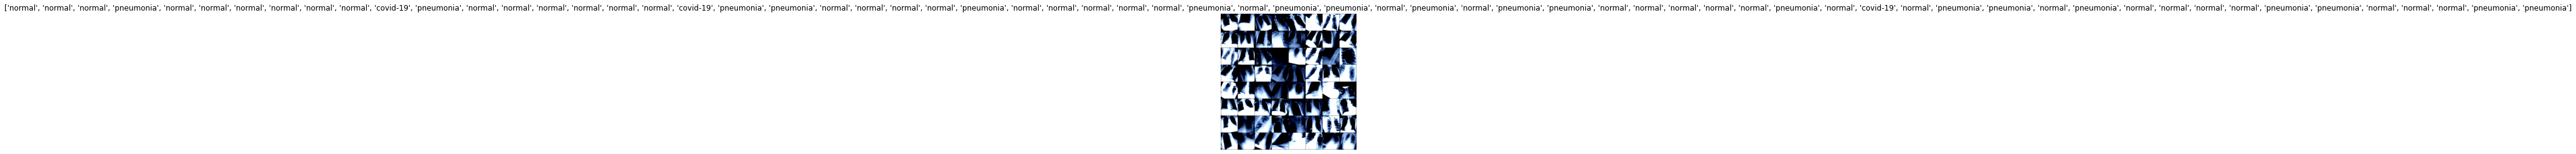

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

# **VGG16 Liklihood Loss**

In [8]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [9]:
features = list(vgg16.classifier.children())[:-7] # Remove last FC layers
features

[]

In [10]:


features.extend([nn.Linear(in_features=25088,out_features=630+100,bias=True)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5,inplace=False)])
features.extend([nn.Linear(in_features=630+100,out_features=3,bias=False)])
features

[Linear(in_features=25088, out_features=730, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=730, out_features=3, bias=False)]

In [11]:
vgg16.classifier=nn.Sequential(*features)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Training **Loop**

In [0]:
def get_num_correct(preds, labs):
    # return preds.argmax(dim=1).eq(labels).sum().item()
    return torch.sum(torch.all(torch.eq(preds, labs),dim=1)).item()
# vg.train(mode=True)

In [0]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
for p in vgg16.parameters():
  print(p.requires_grad)

Train Epoch: 0 [3080/6200 (57%)]	Loss: 0.187527: : 97it [02:33,  1.59s/it]


Train: epoch:  0 total_correct:  3503.0 total_loss:  38.28215442597866 counter: 0
Valid: epoch:  0 total_correct:  523 total_loss:  2.4847749769687653 counter: 0
 


Train Epoch: 1 [3080/6200 (57%)]	Loss: 0.277213: : 97it [02:31,  1.56s/it]


Train: epoch:  1 total_correct:  4867.0 total_loss:  25.364651322364807 counter: 0
Valid: epoch:  1 total_correct:  502 total_loss:  2.4475129395723343 counter: 0
 


Train Epoch: 2 [3080/6200 (57%)]	Loss: 0.296406: : 97it [02:35,  1.60s/it]


Train: epoch:  2 total_correct:  5047.0 total_loss:  22.68407130986452 counter: 0
Valid: epoch:  2 total_correct:  528 total_loss:  1.89115110039711 counter: 0
 


Train Epoch: 3 [3080/6200 (57%)]	Loss: 0.245586: : 97it [02:37,  1.63s/it]


Train: epoch:  3 total_correct:  5103.0 total_loss:  21.065386056900024 counter: 6
Valid: epoch:  3 total_correct:  554 total_loss:  1.744283601641655 counter: 0
 


Train Epoch: 4 [3080/6200 (57%)]	Loss: 0.257753: : 97it [02:35,  1.60s/it]


Train: epoch:  4 total_correct:  5217.0 total_loss:  19.548087894916534 counter: 17
Valid: epoch:  4 total_correct:  559 total_loss:  1.6960364356637 counter: 1
 


Train Epoch: 5 [3080/6200 (57%)]	Loss: 0.168121: : 97it [02:35,  1.61s/it]


Train: epoch:  5 total_correct:  5196.0 total_loss:  19.74391534179449 counter: 21
Valid: epoch:  5 total_correct:  543 total_loss:  1.6869739815592766 counter: 7
 


Train Epoch: 6 [3080/6200 (57%)]	Loss: 0.164696: : 97it [02:36,  1.61s/it]


Train: epoch:  6 total_correct:  5269.0 total_loss:  18.480156406760216 counter: 40
Valid: epoch:  6 total_correct:  532 total_loss:  1.8472280353307724 counter: 4
 


Train Epoch: 7 [3080/6200 (57%)]	Loss: 0.414788: : 97it [02:36,  1.61s/it]


Train: epoch:  7 total_correct:  5273.0 total_loss:  18.426987871527672 counter: 34
Valid: epoch:  7 total_correct:  552 total_loss:  1.887370988726616 counter: 1
 


Train Epoch: 8 [3080/6200 (57%)]	Loss: 0.136617: : 97it [02:36,  1.61s/it]


Train: epoch:  8 total_correct:  5327.0 total_loss:  17.89401114732027 counter: 42
Valid: epoch:  8 total_correct:  562 total_loss:  1.5674025304615498 counter: 5
 


Train Epoch: 9 [3080/6200 (57%)]	Loss: 0.105229: : 97it [02:34,  1.60s/it]


Train: epoch:  9 total_correct:  5373.0 total_loss:  17.022392854094505 counter: 62
Valid: epoch:  9 total_correct:  566 total_loss:  1.3273247629404068 counter: 5
 
Training Accuracy 86.66129032258064 %
Validation Accuracy 90.12738853503184 %
Finished Training


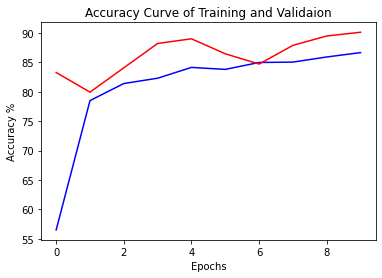

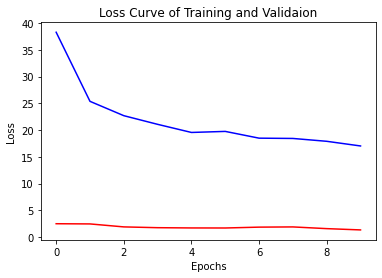

(3, 3)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


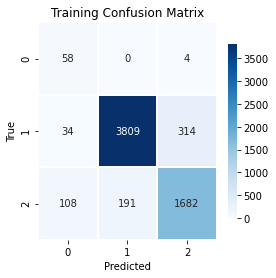

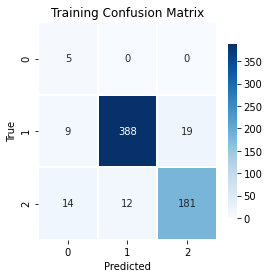

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  vgg16.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # 
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    label=labels
    labels= torch.nn.functional.one_hot(labels, len(class_names))
    for i in range(labels[:,0].shape[0]):
      if(labels[:,0][i]==1):
        labels[:,2][i]=1

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = vgg16(inputs)               #----> forward pass
    # _, predict = torch.max(outputs.data, 1)
  
    loss = criterion(outputs, labels.float())   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    
    limit = Variable(torch.Tensor([0.50])).to(device)
    # # print("Before",outputs)
    # # outputs=torch.Sigmoid(outputs)
    # o=outputs.cpu()
    # o=o.detach().numpy()
    # outputs = 1/(1 + np.exp(-o))
    # # print("Afterr",outputs)
    
    predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    # print("labeleddd", labels)
    # print("outputedd",outputs)
    # print("predicted", predicted)
    
    # total_correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    total_correct += get_num_correct(predicted, labels)
    
    predicted= predicted.cpu().numpy()
    outputs= outputs.cpu().detach().numpy()
    # print("After",predicted)

    for i in range(outputs.shape[0]):
      
      
      
      if (predicted[i]==[1,0,1]).all():
        train_p.extend([0])
        counter+=1
      elif (predicted[i]==[0,1,0]).all():
        train_p.extend([1])
      elif (predicted[i]==[0,0,1]).all():
         train_p.extend([2])
      else:
          l=outputs[i].argmax(axis=0)
          # print("Predicted",predicted[i])
          # print("label:",l)
          train_p.extend([l])

        



    # train_p.extend(predicted)
    train_l.extend(label.cpu().numpy())

    # print("train predicted",train_p)
    
    # print("train label",train_l)

    pbar.set_description(
        
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss,"counter:",counter)
  torch.save(vgg16,"vgg16_liklihood_loss.pth")

  vgg16.eval()
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import multilabel_confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  counter=0
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          label=labels
          labels= torch.nn.functional.one_hot(labels, len(class_names))
          for i in range(labels[:,0].shape[0]):
            if(labels[:,0][i]==1):
              labels[:,2][i]=1


          outputs = vgg16(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)

          limit = Variable(torch.Tensor([0.50])).to(device)
          predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    

          loss = criterion(outputs, labels.float())

          correct += get_num_correct(predicted, labels)
          # print("Predicted",predicted)
          # print("Labels",labels)
          
          running_loss += loss.item()
          predicted= predicted.cpu().numpy()
          outputs=outputs.cpu().detach().numpy()

          for i in range(outputs.shape[0]):
            
            
            
            if (predicted[i]==[1,0,1]).all():
              valid_p.extend([0])
              counter+=1
            elif (predicted[i]==[0,1,0]).all():
              valid_p.extend([1])
            elif (predicted[i]==[0,0,1]).all():
              valid_p.extend([2])              # labels[:,2][i]=1
            else:
              l=outputs[i].argmax(axis=0)
              # print("Predicted",predicted[i])
              # print("label:",l)
              valid_p.extend([l])
              
              
            
          # valid_p.extend(predicted)
          valid_l.extend(label.cpu().numpy())
          # print(".",correct)
  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss,"counter:",counter)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)
print(train_input.shape)
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

5
 
Validation Accuracy 90.12738853503184 %
Validation F1 Score : 0.9140127388535032


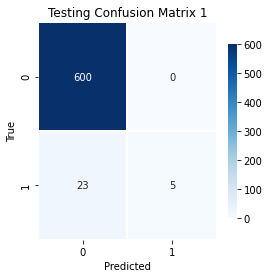

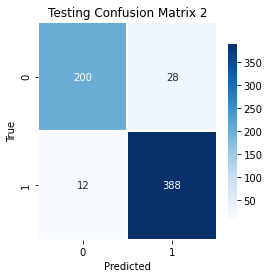

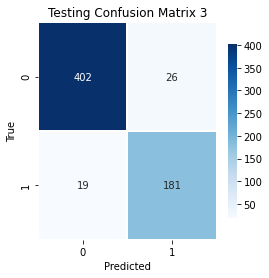

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score


vgg16=torch.load("vgg16_liklihood_loss.pth")
vgg16.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

correct = 0
total = 0

running_loss=0.0

valid_p=[]
valid_l=[]
counter=0
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        label=labels
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        for i in range(labels[:,0].shape[0]):
          if(labels[:,0][i]==1):
            labels[:,2][i]=1


        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        limit = Variable(torch.Tensor([0.50])).to(device)
        predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
  

        loss = criterion(outputs, labels.float())

        correct += get_num_correct(predicted, labels)
        # print("Predicted",predicted)
        # print("Labels",labels)
        
        running_loss += loss.item()
        predicted= predicted.cpu().numpy()
        outputs=outputs.cpu().detach().numpy()

        for i in range(outputs.shape[0]):
          
          
          
          if (predicted[i]==[1,0,1]).all():
            valid_p.extend([0])
            counter+=1
          elif (predicted[i]==[0,1,0]).all():
            valid_p.extend([1])
          elif (predicted[i]==[0,0,1]).all():
            valid_p.extend([2])              # labels[:,2][i]=1
          else:
            l=outputs[i].argmax(axis=0)
            # print("Predicted",predicted[i])
            # print("label:",l)
            valid_p.extend([l])
            
            
          
        # valid_p.extend(predicted)
        valid_l.extend(label.cpu().numpy())
        # print(".",correct)
# valid_acc.append((100 * correct) / total)
# valid_loss.append(running_loss)
print(counter)
print(" ")


print("Validation Accuracy",((100 * correct) / total),"%")
print("Validation F1 Score :",f1_score(valid_l, valid_p, average="micro")) # p are predicted labels and l are true labels

valid_input=multilabel_confusion_matrix(valid_l,valid_p)

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input[0],cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix 1")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input[1],cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix 2")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input[2],cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix 3")
plt.show()


# f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="micro"))

LR 0.01

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [0]:
features = list(vgg16.classifier.children())[:-7] # Remove last FC layers


features.extend([nn.Linear(in_features=25088,out_features=630+100,bias=True)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5,inplace=False)])
features.extend([nn.Linear(in_features=630+100,out_features=3,bias=False)])
features

[Linear(in_features=25088, out_features=730, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=730, out_features=3, bias=False)]

In [0]:
vgg16.classifier=nn.Sequential(*features)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Training loop

In [0]:
def get_num_correct(preds, labs):
    # return preds.argmax(dim=1).eq(labels).sum().item()
    return torch.sum(torch.all(torch.eq(preds, labs),dim=1)).item()
# vg.train(mode=True)

In [0]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9)

Train Epoch: 0 [3080/6200 (57%)]	Loss: 0.254705: : 97it [02:59,  1.85s/it]


Train: epoch:  0 total_correct:  4405.0 total_loss:  30.298244804143906 counter: 0
Valid: epoch:  0 total_correct:  541 total_loss:  1.957199901342392 counter: 0
 


Train Epoch: 1 [3080/6200 (57%)]	Loss: 0.190272: : 97it [02:59,  1.85s/it]


Train: epoch:  1 total_correct:  4922.0 total_loss:  24.97202080488205 counter: 1
Valid: epoch:  1 total_correct:  547 total_loss:  1.7609813213348389 counter: 0
 


Train Epoch: 2 [3080/6200 (57%)]	Loss: 0.217015: : 97it [02:57,  1.83s/it]


Train: epoch:  2 total_correct:  5111.0 total_loss:  21.74519784003496 counter: 6
Valid: epoch:  2 total_correct:  561 total_loss:  1.6551503166556358 counter: 13
 


Train Epoch: 3 [3080/6200 (57%)]	Loss: 0.161144: : 97it [02:57,  1.83s/it]


Train: epoch:  3 total_correct:  5251.0 total_loss:  19.134415701031685 counter: 29
Valid: epoch:  3 total_correct:  543 total_loss:  1.4855733513832092 counter: 2
 


Train Epoch: 4 [3080/6200 (57%)]	Loss: 0.233249: : 97it [02:56,  1.82s/it]


Train: epoch:  4 total_correct:  5259.0 total_loss:  18.756306879222393 counter: 33
Valid: epoch:  4 total_correct:  568 total_loss:  1.6592378988862038 counter: 11
 


Train Epoch: 5 [3080/6200 (57%)]	Loss: 0.122930: : 97it [02:56,  1.82s/it]


Train: epoch:  5 total_correct:  5261.0 total_loss:  19.308332063257694 counter: 37
Valid: epoch:  5 total_correct:  554 total_loss:  1.5964685454964638 counter: 18
 


Train Epoch: 6 [3080/6200 (57%)]	Loss: 0.132951: : 97it [02:57,  1.83s/it]


Train: epoch:  6 total_correct:  5326.0 total_loss:  18.32006799429655 counter: 58
Valid: epoch:  6 total_correct:  570 total_loss:  1.4575506523251534 counter: 12
 


Train Epoch: 7 [3080/6200 (57%)]	Loss: 0.107509: : 97it [02:57,  1.83s/it]


Train: epoch:  7 total_correct:  5376.0 total_loss:  17.35449769347906 counter: 50
Valid: epoch:  7 total_correct:  531 total_loss:  1.7392012998461723 counter: 16
 


Train Epoch: 8 [3080/6200 (57%)]	Loss: 0.186050: : 97it [02:59,  1.85s/it]


Train: epoch:  8 total_correct:  5325.0 total_loss:  17.403732977807522 counter: 52
Valid: epoch:  8 total_correct:  562 total_loss:  1.3347954228520393 counter: 22
 


Train Epoch: 9 [3080/6200 (57%)]	Loss: 0.275470: : 97it [02:58,  1.84s/it]


Train: epoch:  9 total_correct:  5204.0 total_loss:  19.861279375851154 counter: 59
Valid: epoch:  9 total_correct:  576 total_loss:  1.4071014374494553 counter: 12
 
Training Accuracy 83.93548387096774 %
Validation Accuracy 91.71974522292993 %
Finished Training


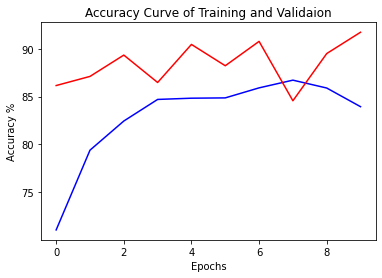

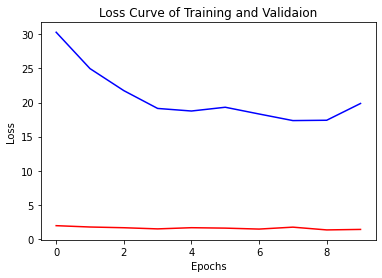

(3, 3)


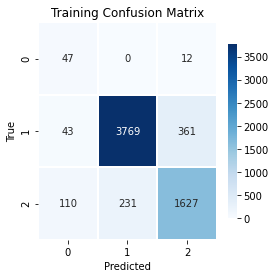

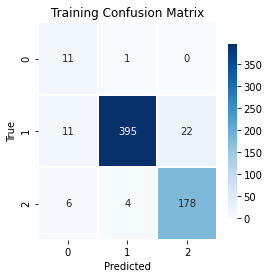

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  vgg16.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # 
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    label=labels
    labels= torch.nn.functional.one_hot(labels, len(class_names))
    for i in range(labels[:,0].shape[0]):
      if(labels[:,0][i]==1):
        labels[:,2][i]=1

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = vgg16(inputs)               #----> forward pass
    # _, predict = torch.max(outputs.data, 1)
  
    loss = criterion(outputs, labels.float())   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    
    limit = Variable(torch.Tensor([0.50])).to(device)
    # # print("Before",outputs)
    # # outputs=torch.Sigmoid(outputs)
    # o=outputs.cpu()
    # o=o.detach().numpy()
    # outputs = 1/(1 + np.exp(-o))
    # # print("Afterr",outputs)
    
    predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    # print("labeleddd", labels)
    # print("outputedd",outputs)
    # print("predicted", predicted)
    
    # total_correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    total_correct += get_num_correct(predicted, labels)
    
    predicted= predicted.cpu().numpy()
    outputs= outputs.cpu().detach().numpy()
    # print("After",predicted)

    for i in range(outputs.shape[0]):
      
      
      
      if (predicted[i]==[1,0,1]).all():
        train_p.extend([0])
        counter+=1
      elif (predicted[i]==[0,1,0]).all():
        train_p.extend([1])
      elif (predicted[i]==[0,0,1]).all():
         train_p.extend([2])
      else:
          l=outputs[i].argmax(axis=0)
          # print("Predicted",predicted[i])
          # print("label:",l)
          train_p.extend([l])

        



    # train_p.extend(predicted)
    train_l.extend(label.cpu().numpy())

    # print("train predicted",train_p)
    
    # print("train label",train_l)

    pbar.set_description(
        
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss,"counter:",counter)
  torch.save(vgg16,"vgg16_liklihood_loss_LR_0.01.pth")

  vgg16.eval()
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import multilabel_confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  counter=0
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          label=labels
          labels= torch.nn.functional.one_hot(labels, len(class_names))
          for i in range(labels[:,0].shape[0]):
            if(labels[:,0][i]==1):
              labels[:,2][i]=1


          outputs = vgg16(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)

          limit = Variable(torch.Tensor([0.50])).to(device)
          predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    

          loss = criterion(outputs, labels.float())

          correct += get_num_correct(predicted, labels)
          # print("Predicted",predicted)
          # print("Labels",labels)
          
          running_loss += loss.item()
          predicted= predicted.cpu().numpy()
          outputs=outputs.cpu().detach().numpy()

          for i in range(outputs.shape[0]):
            
            
            
            if (predicted[i]==[1,0,1]).all():
              valid_p.extend([0])
              counter+=1
            elif (predicted[i]==[0,1,0]).all():
              valid_p.extend([1])
            elif (predicted[i]==[0,0,1]).all():
              valid_p.extend([2])              # labels[:,2][i]=1
            else:
              l=outputs[i].argmax(axis=0)
              # print("Predicted",predicted[i])
              # print("label:",l)
              valid_p.extend([l])
              
              
            
          # valid_p.extend(predicted)
          valid_l.extend(label.cpu().numpy())
          # print(".",correct)
  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss,"counter:",counter)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)
print(train_input.shape)
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

12
 
Validation Accuracy 91.71974522292993 %
Validation F1 Score : 0.9299363057324841


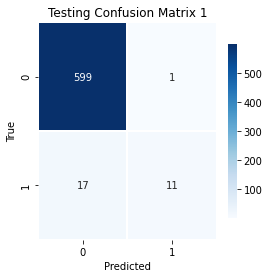

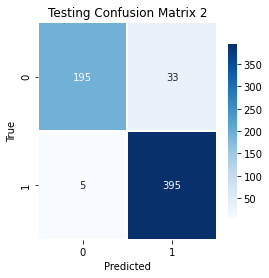

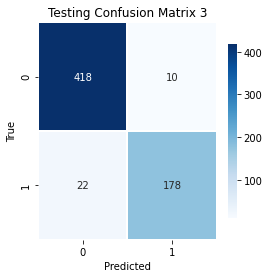

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score


vgg16=torch.load("vgg16_liklihood_loss_LR_0.01.pth")
vgg16.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

correct = 0
total = 0

running_loss=0.0

valid_p=[]
valid_l=[]
counter=0
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        label=labels
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        for i in range(labels[:,0].shape[0]):
          if(labels[:,0][i]==1):
            labels[:,2][i]=1


        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        limit = Variable(torch.Tensor([0.50])).to(device)
        predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
  

        loss = criterion(outputs, labels.float())

        correct += get_num_correct(predicted, labels)
        # print("Predicted",predicted)
        # print("Labels",labels)
        
        running_loss += loss.item()
        predicted= predicted.cpu().numpy()
        outputs=outputs.cpu().detach().numpy()

        for i in range(outputs.shape[0]):
          
          
          
          if (predicted[i]==[1,0,1]).all():
            valid_p.extend([0])
            counter+=1
          elif (predicted[i]==[0,1,0]).all():
            valid_p.extend([1])
          elif (predicted[i]==[0,0,1]).all():
            valid_p.extend([2])              # labels[:,2][i]=1
          else:
            l=outputs[i].argmax(axis=0)
            # print("Predicted",predicted[i])
            # print("label:",l)
            valid_p.extend([l])
            
            
          
        # valid_p.extend(predicted)
        valid_l.extend(label.cpu().numpy())
        # print(".",correct)
# valid_acc.append((100 * correct) / total)
# valid_loss.append(running_loss)
print(counter)
print(" ")


print("Validation Accuracy",((100 * correct) / total),"%")
print("Validation F1 Score :",f1_score(valid_l, valid_p, average="micro")) # p are predicted labels and l are true labels

valid_input=multilabel_confusion_matrix(valid_l,valid_p)

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input[0],cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix 1")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input[1],cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix 2")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input[2],cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix 3")
plt.show()


# f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="micro"))

# **Train Resnet-18**

In [0]:
resnet18=models.resnet18(pretrained=True, progress=True)
print("hi")

features=[]
features.extend([nn.Linear(in_features=512,out_features=630+100,bias=True)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5,inplace=False)])
features.extend([nn.Linear(in_features=630+100,out_features=3,bias=False)])
resnet18.fc=nn.Sequential(*features)
resnet18

hi


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
def get_num_correct(preds, labs):
    # return preds.argmax(dim=1).eq(labels).sum().item()
    return torch.sum(torch.all(torch.eq(preds, labs),dim=1)).item()
# vg.train(mode=True)

In [0]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)


Train Epoch: 0 [3080/6200 (57%)]	Loss: 0.382488: : 97it [02:20,  1.45s/it]


Train: epoch:  0 total_correct:  2697.0 total_loss:  45.004962891340256 counter: 0
Valid: epoch:  0 total_correct:  377 total_loss:  3.8418435752391815 counter: 0
 


Train Epoch: 1 [3080/6200 (57%)]	Loss: 0.244758: : 97it [02:20,  1.45s/it]


Train: epoch:  1 total_correct:  4010.0 total_loss:  33.14647679030895 counter: 0
Valid: epoch:  1 total_correct:  495 total_loss:  2.791406884789467 counter: 0
 


Train Epoch: 2 [3080/6200 (57%)]	Loss: 0.258693: : 97it [02:21,  1.46s/it]


Train: epoch:  2 total_correct:  4743.0 total_loss:  27.111137837171555 counter: 0
Valid: epoch:  2 total_correct:  520 total_loss:  2.392234683036804 counter: 0
 


Train Epoch: 3 [3080/6200 (57%)]	Loss: 0.199729: : 97it [02:20,  1.45s/it]


Train: epoch:  3 total_correct:  4959.0 total_loss:  24.256866171956062 counter: 0
Valid: epoch:  3 total_correct:  516 total_loss:  2.231047123670578 counter: 0
 


Train Epoch: 4 [3080/6200 (57%)]	Loss: 0.281453: : 97it [02:22,  1.47s/it]


Train: epoch:  4 total_correct:  5055.0 total_loss:  22.94737759232521 counter: 0
Valid: epoch:  4 total_correct:  546 total_loss:  2.050184488296509 counter: 0
 


Train Epoch: 5 [3080/6200 (57%)]	Loss: 0.221700: : 97it [02:21,  1.46s/it]


Train: epoch:  5 total_correct:  5157.0 total_loss:  21.11675189435482 counter: 0
Valid: epoch:  5 total_correct:  546 total_loss:  1.9353617131710052 counter: 0
 


Train Epoch: 6 [3080/6200 (57%)]	Loss: 0.224024: : 97it [02:22,  1.46s/it]


Train: epoch:  6 total_correct:  5166.0 total_loss:  20.354544170200825 counter: 0
Valid: epoch:  6 total_correct:  539 total_loss:  1.8603053987026215 counter: 0
 


Train Epoch: 7 [3080/6200 (57%)]	Loss: 0.184748: : 97it [02:22,  1.46s/it]


Train: epoch:  7 total_correct:  5187.0 total_loss:  20.087342388927937 counter: 0
Valid: epoch:  7 total_correct:  542 total_loss:  1.8712178170681 counter: 0
 


Train Epoch: 8 [3080/6200 (57%)]	Loss: 0.215539: : 97it [02:20,  1.45s/it]


Train: epoch:  8 total_correct:  5243.0 total_loss:  19.053846515715122 counter: 0
Valid: epoch:  8 total_correct:  549 total_loss:  1.7202584519982338 counter: 0
 


Train Epoch: 9 [3080/6200 (57%)]	Loss: 0.163439: : 97it [02:20,  1.45s/it]


Train: epoch:  9 total_correct:  5223.0 total_loss:  19.209906861186028 counter: 0
Valid: epoch:  9 total_correct:  514 total_loss:  2.1142591387033463 counter: 0
 
Training Accuracy 84.24193548387096 %
Validation Accuracy 81.84713375796179 %
Finished Training


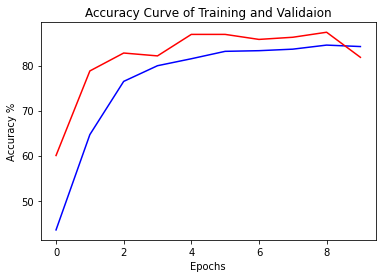

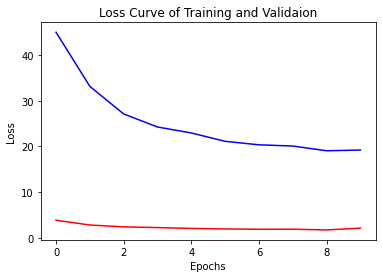

(3, 3)


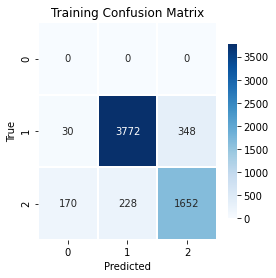

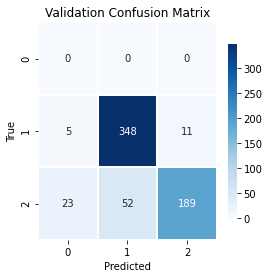

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  resnet18.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # 
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    label=labels
    labels= torch.nn.functional.one_hot(labels, len(class_names))
    for i in range(labels[:,0].shape[0]):
      if(labels[:,0][i]==1):
        labels[:,2][i]=1

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = resnet18(inputs)               #----> forward pass
    # _, predict = torch.max(outputs.data, 1)
  
    loss = criterion(outputs, labels.float())   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    
    limit = Variable(torch.Tensor([0.50])).to(device)
    # # print("Before",outputs)
    # # outputs=torch.Sigmoid(outputs)
    # o=outputs.cpu()
    # o=o.detach().numpy()
    # outputs = 1/(1 + np.exp(-o))
    # # print("Afterr",outputs)
    
    predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    # print("labeleddd", labels)
    # print("outputedd",outputs)
    # print("predicted", predicted)
    
    # total_correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    total_correct += get_num_correct(predicted, labels)
    
    predicted= predicted.cpu().numpy()
    outputs= outputs.cpu().detach().numpy()
    # print("After",predicted)

    for i in range(outputs.shape[0]):
      
      
      
      if (predicted[i]==[1,0,1]).all():
        train_p.extend([0])
        counter+=1
      elif (predicted[i]==[0,1,0]).all():
        train_p.extend([1])
      elif (predicted[i]==[0,0,1]).all():
         train_p.extend([2])
      else:
          l=outputs[i].argmax(axis=0)
          # print("Predicted",predicted[i])
          # print("label:",l)
          train_p.extend([l])

        



    # train_p.extend(predicted)
    train_l.extend(label.cpu().numpy())

    # print("train predicted",train_p)
    
    # print("train label",train_l)

    pbar.set_description(
        
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss,"counter:",counter)
  torch.save(resnet18,"resnet18_liklihood_loss.pth")

  resnet18.eval()
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import multilabel_confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  counter=0
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          label=labels
          labels= torch.nn.functional.one_hot(labels, len(class_names))
          for i in range(labels[:,0].shape[0]):
            if(labels[:,0][i]==1):
              labels[:,2][i]=1


          outputs = resnet18(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)

          limit = Variable(torch.Tensor([0.50])).to(device)
          predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    

          loss = criterion(outputs, labels.float())

          correct += get_num_correct(predicted, labels)
          # print("Predicted",predicted)
          # print("Labels",labels)
          
          running_loss += loss.item()
          predicted= predicted.cpu().numpy()
          outputs=outputs.cpu().detach().numpy()

          for i in range(outputs.shape[0]):
            
            
            
            if (predicted[i]==[1,0,1]).all():
              valid_p.extend([0])
              counter+=1
            elif (predicted[i]==[0,1,0]).all():
              valid_p.extend([1])
            elif (predicted[i]==[0,0,1]).all():
              valid_p.extend([2])              # labels[:,2][i]=1
            else:
              l=outputs[i].argmax(axis=0)
              # print("Predicted",predicted[i])
              # print("label:",l)
              valid_p.extend([l])
              
              
            
          # valid_p.extend(predicted)
          valid_l.extend(label.cpu().numpy())
          # print(".",correct)
  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss,"counter:",counter)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)
print(train_input.shape)
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Validation Confusion Matrix")
plt.show()

0
 
Validation Accuracy 81.84713375796179 %
Validation F1 Score : 0.8550955414012739


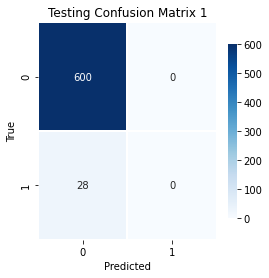

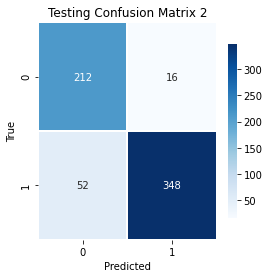

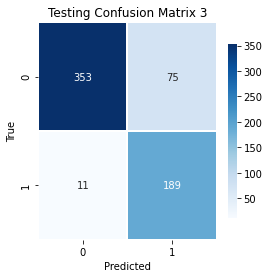

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score


resnet18=torch.load("resnet18_liklihood_loss.pth")
resnet18.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

correct = 0
total = 0

running_loss=0.0

valid_p=[]
valid_l=[]
counter=0
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        label=labels
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        for i in range(labels[:,0].shape[0]):
          if(labels[:,0][i]==1):
            labels[:,2][i]=1


        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        limit = Variable(torch.Tensor([0.50])).to(device)
        predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
  

        loss = criterion(outputs, labels.float())

        correct += get_num_correct(predicted, labels)
        # print("Predicted",predicted)
        # print("Labels",labels)
        
        running_loss += loss.item()
        predicted= predicted.cpu().numpy()
        outputs=outputs.cpu().detach().numpy()

        for i in range(outputs.shape[0]):
          
          
          
          if (predicted[i]==[1,0,1]).all():
            valid_p.extend([0])
            counter+=1
          elif (predicted[i]==[0,1,0]).all():
            valid_p.extend([1])
          elif (predicted[i]==[0,0,1]).all():
            valid_p.extend([2])              # labels[:,2][i]=1
          else:
            l=outputs[i].argmax(axis=0)
            # print("Predicted",predicted[i])
            # print("label:",l)
            valid_p.extend([l])
            
            
          
        # valid_p.extend(predicted)
        valid_l.extend(label.cpu().numpy())
        # print(".",correct)
# valid_acc.append((100 * correct) / total)
# valid_loss.append(running_loss)
print(counter)
print(" ")


print("Validation Accuracy",((100 * correct) / total),"%")
print("Validation F1 Score :",f1_score(valid_l, valid_p, average="micro")) # p are predicted labels and l are true labels

valid_input=multilabel_confusion_matrix(valid_l,valid_p)

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input[0],cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix 1")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input[1],cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix 2")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input[2],cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix 3")
plt.show()


# f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="micro"))

LR= 0.01

In [0]:
resnet18=models.resnet18(pretrained=True, progress=True)
print("hi")

features=[]
features.extend([nn.Linear(in_features=512,out_features=630+100,bias=True)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5,inplace=False)])
features.extend([nn.Linear(in_features=630+100,out_features=3,bias=False)])
resnet18.fc=nn.Sequential(*features)
resnet18

hi


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
def get_num_correct(preds, labs):
    # return preds.argmax(dim=1).eq(labels).sum().item()
    return torch.sum(torch.all(torch.eq(preds, labs),dim=1)).item()
# vg.train(mode=True)

In [0]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9)


Train Epoch: 0 [3080/6200 (57%)]	Loss: 0.364482: : 97it [02:21,  1.46s/it]


Train: epoch:  0 total_correct:  4183.0 total_loss:  32.12821691483259 counter: 0
Valid: epoch:  0 total_correct:  541 total_loss:  1.9312944263219833 counter: 0
 


Train Epoch: 1 [3080/6200 (57%)]	Loss: 0.199137: : 97it [02:21,  1.46s/it]


Train: epoch:  1 total_correct:  5090.0 total_loss:  22.43647049367428 counter: 0
Valid: epoch:  1 total_correct:  535 total_loss:  2.2703523337841034 counter: 0
 


Train Epoch: 2 [3080/6200 (57%)]	Loss: 0.175592: : 97it [02:19,  1.44s/it]


Train: epoch:  2 total_correct:  5215.0 total_loss:  20.084112770855427 counter: 0
Valid: epoch:  2 total_correct:  518 total_loss:  2.0299725979566574 counter: 0
 


Train Epoch: 3 [3080/6200 (57%)]	Loss: 0.141549: : 97it [02:19,  1.44s/it]


Train: epoch:  3 total_correct:  5243.0 total_loss:  18.872785210609436 counter: 14
Valid: epoch:  3 total_correct:  566 total_loss:  1.4902332425117493 counter: 5
 


Train Epoch: 4 [3080/6200 (57%)]	Loss: 0.243893: : 97it [02:20,  1.44s/it]


Train: epoch:  4 total_correct:  5352.0 total_loss:  17.591864466667175 counter: 64
Valid: epoch:  4 total_correct:  495 total_loss:  3.2611627727746964 counter: 46
 


Train Epoch: 5 [3080/6200 (57%)]	Loss: 0.082272: : 97it [02:17,  1.42s/it]


Train: epoch:  5 total_correct:  5377.0 total_loss:  16.824077419936657 counter: 75
Valid: epoch:  5 total_correct:  584 total_loss:  1.1398016214370728 counter: 19
 


Train Epoch: 6 [3080/6200 (57%)]	Loss: 0.172297: : 97it [02:18,  1.43s/it]


Train: epoch:  6 total_correct:  5405.0 total_loss:  17.128957621753216 counter: 82
Valid: epoch:  6 total_correct:  581 total_loss:  1.1262001134455204 counter: 26
 


Train Epoch: 7 [3080/6200 (57%)]	Loss: 0.161240: : 97it [02:19,  1.44s/it]


Train: epoch:  7 total_correct:  5447.0 total_loss:  16.072816126048565 counter: 90
Valid: epoch:  7 total_correct:  553 total_loss:  1.7166793048381805 counter: 33
 


Train Epoch: 8 [3080/6200 (57%)]	Loss: 0.175743: : 97it [02:19,  1.43s/it]


Train: epoch:  8 total_correct:  5433.0 total_loss:  15.957206889986992 counter: 96
Valid: epoch:  8 total_correct:  536 total_loss:  1.9585088342428207 counter: 39
 


Train Epoch: 9 [3080/6200 (57%)]	Loss: 0.165026: : 97it [02:21,  1.46s/it]


Train: epoch:  9 total_correct:  5449.0 total_loss:  15.364845752716064 counter: 103
Valid: epoch:  9 total_correct:  578 total_loss:  1.222476053982973 counter: 12
 
Training Accuracy 87.88709677419355 %
Validation Accuracy 92.03821656050955 %
Finished Training


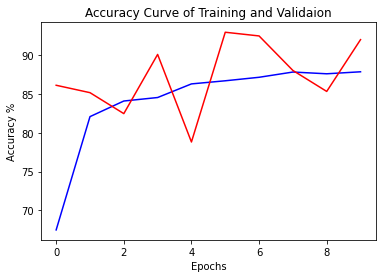

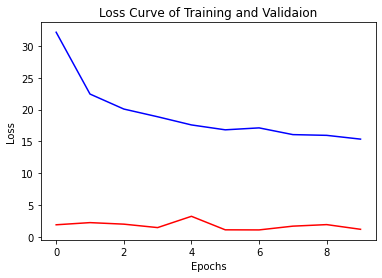

(3, 3)


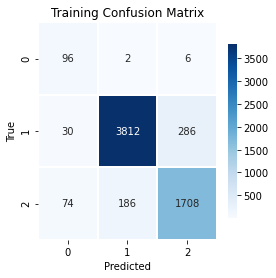

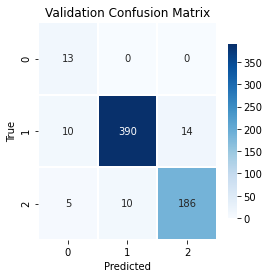

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  resnet18.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # 
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    label=labels
    labels= torch.nn.functional.one_hot(labels, len(class_names))
    for i in range(labels[:,0].shape[0]):
      if(labels[:,0][i]==1):
        labels[:,2][i]=1

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = resnet18(inputs)               #----> forward pass
    # _, predict = torch.max(outputs.data, 1)
  
    loss = criterion(outputs, labels.float())   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    
    limit = Variable(torch.Tensor([0.50])).to(device)
    # # print("Before",outputs)
    # # outputs=torch.Sigmoid(outputs)
    # o=outputs.cpu()
    # o=o.detach().numpy()
    # outputs = 1/(1 + np.exp(-o))
    # # print("Afterr",outputs)
    
    predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    # print("labeleddd", labels)
    # print("outputedd",outputs)
    # print("predicted", predicted)
    
    # total_correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    total_correct += get_num_correct(predicted, labels)
    
    predicted= predicted.cpu().numpy()
    outputs= outputs.cpu().detach().numpy()
    # print("After",predicted)

    for i in range(outputs.shape[0]):
      
      
      
      if (predicted[i]==[1,0,1]).all():
        train_p.extend([0])
        counter+=1
      elif (predicted[i]==[0,1,0]).all():
        train_p.extend([1])
      elif (predicted[i]==[0,0,1]).all():
         train_p.extend([2])
      else:
          l=outputs[i].argmax(axis=0)
          # print("Predicted",predicted[i])
          # print("label:",l)
          train_p.extend([l])

        



    # train_p.extend(predicted)
    train_l.extend(label.cpu().numpy())

    # print("train predicted",train_p)
    
    # print("train label",train_l)

    pbar.set_description(
        
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss,"counter:",counter)
  torch.save(resnet18,"resnet18_liklihood_loss_LR_0.01.pth")

  resnet18.eval()
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import multilabel_confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  counter=0
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          label=labels
          labels= torch.nn.functional.one_hot(labels, len(class_names))
          for i in range(labels[:,0].shape[0]):
            if(labels[:,0][i]==1):
              labels[:,2][i]=1


          outputs = resnet18(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)

          limit = Variable(torch.Tensor([0.50])).to(device)
          predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    

          loss = criterion(outputs, labels.float())

          correct += get_num_correct(predicted, labels)
          # print("Predicted",predicted)
          # print("Labels",labels)
          
          running_loss += loss.item()
          predicted= predicted.cpu().numpy()
          outputs=outputs.cpu().detach().numpy()

          for i in range(outputs.shape[0]):
            
            
            
            if (predicted[i]==[1,0,1]).all():
              valid_p.extend([0])
              counter+=1
            elif (predicted[i]==[0,1,0]).all():
              valid_p.extend([1])
            elif (predicted[i]==[0,0,1]).all():
              valid_p.extend([2])              # labels[:,2][i]=1
            else:
              l=outputs[i].argmax(axis=0)
              # print("Predicted",predicted[i])
              # print("label:",l)
              valid_p.extend([l])
              
              
            
          # valid_p.extend(predicted)
          valid_l.extend(label.cpu().numpy())
          # print(".",correct)
  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss,"counter:",counter)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)
print(train_input.shape)
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Validation Confusion Matrix")
plt.show()

12
 
Validation Accuracy 92.03821656050955 %
Validation F1 Score : 0.9378980891719745


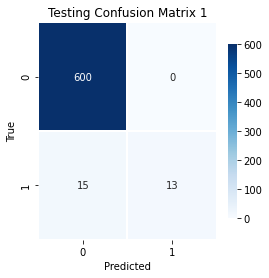

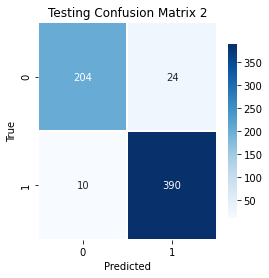

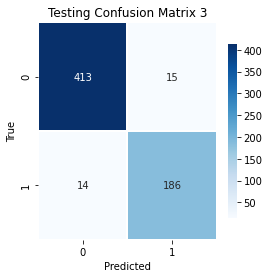

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score


resnet18=torch.load("resnet18_liklihood_loss_LR_0.01.pth")
resnet18.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

correct = 0
total = 0

running_loss=0.0

valid_p=[]
valid_l=[]
counter=0
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        label=labels
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        for i in range(labels[:,0].shape[0]):
          if(labels[:,0][i]==1):
            labels[:,2][i]=1


        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        limit = Variable(torch.Tensor([0.50])).to(device)
        predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
  

        loss = criterion(outputs, labels.float())

        correct += get_num_correct(predicted, labels)
        # print("Predicted",predicted)
        # print("Labels",labels)
        
        running_loss += loss.item()
        predicted= predicted.cpu().numpy()
        outputs=outputs.cpu().detach().numpy()

        for i in range(outputs.shape[0]):
          
          
          
          if (predicted[i]==[1,0,1]).all():
            valid_p.extend([0])
            counter+=1
          elif (predicted[i]==[0,1,0]).all():
            valid_p.extend([1])
          elif (predicted[i]==[0,0,1]).all():
            valid_p.extend([2])              # labels[:,2][i]=1
          else:
            l=outputs[i].argmax(axis=0)
            # print("Predicted",predicted[i])
            # print("label:",l)
            valid_p.extend([l])
            
            
          
        # valid_p.extend(predicted)
        valid_l.extend(label.cpu().numpy())
        # print(".",correct)
# valid_acc.append((100 * correct) / total)
# valid_loss.append(running_loss)
print(counter)
print(" ")


print("Validation Accuracy",((100 * correct) / total),"%")
print("Validation F1 Score :",f1_score(valid_l, valid_p, average="micro")) # p are predicted labels and l are true labels

valid_input=multilabel_confusion_matrix(valid_l,valid_p)

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input[0],cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix 1")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input[1],cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix 2")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input[2],cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix 3")
plt.show()


# f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="micro"))

# **# TASK 2 ( FOCAL LOSS )**

In [0]:
class FocalLoss(nn.Module):

  def __init__(self,alpha,gamma):
    self.alpha=alpha
    self.gamma=gamma

    super().__init__()
    self.nll_loss = nn.BCEWithLogitsLoss()
  
  def forward(self,output,target):
    BCELoss=-(self.nll_loss(output,target))
    
    Pt=torch.exp(BCELoss)
    Standard_Focal_Loss=-((1-Pt)**self.gamma)*BCELoss
    Alpha_Balanced_Focal_Loss=self.alpha*Standard_Focal_Loss
    return Alpha_Balanced_Focal_Loss


## **Train VGG16** *Focal Loss*

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
features = list(vgg16.classifier.children())[:-7] # Remove last FC layers
features

[]

In [0]:
features.extend([nn.Linear(in_features=25088,out_features=630+100,bias=True)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5,inplace=False)])
features.extend([nn.Linear(in_features=630+100,out_features=3,bias=False)])
features

[Linear(in_features=25088, out_features=730, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=730, out_features=3, bias=False)]

In [0]:
vgg16.classifier=nn.Sequential(*features)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# **Training Loop (Alpha=0.5, Gamma=2, LR=0.001)**


In [0]:
def get_num_correct(preds, labs):
    # return preds.argmax(dim=1).eq(labels).sum().item()
    return torch.sum(torch.all(torch.eq(preds, labs),dim=1)).item()
# vg.train(mode=True)

Epochs = 10
# criterion = nn.BCEWithLogitsLoss()
criterion=FocalLoss(alpha=0.5,gamma=2)
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

Train Epoch: 0 [3080/6200 (57%)]	Loss: 0.019508: : 97it [20:30, 12.68s/it]


Train: epoch:  0 total_correct:  2652.0 total_loss:  3.6534231919795275 counter: 0
Valid: epoch:  0 total_correct:  386 total_loss:  0.21997474879026413 counter: 0
 


Train Epoch: 1 [3080/6200 (57%)]	Loss: 0.019911: : 97it [02:09,  1.33s/it]


Train: epoch:  1 total_correct:  3192.0 total_loss:  2.10656326636672 counter: 0
Valid: epoch:  1 total_correct:  452 total_loss:  0.14018483832478523 counter: 0
 


Train Epoch: 2 [3080/6200 (57%)]	Loss: 0.006533: : 97it [02:09,  1.34s/it]


Train: epoch:  2 total_correct:  3891.0 total_loss:  1.521448093932122 counter: 0
Valid: epoch:  2 total_correct:  505 total_loss:  0.09536035149358213 counter: 0
 


Train Epoch: 3 [3080/6200 (57%)]	Loss: 0.006121: : 97it [02:09,  1.33s/it]


Train: epoch:  3 total_correct:  4326.0 total_loss:  1.1738187251612544 counter: 0
Valid: epoch:  3 total_correct:  519 total_loss:  0.08070231997407973 counter: 0
 


Train Epoch: 4 [3080/6200 (57%)]	Loss: 0.011196: : 97it [02:10,  1.35s/it]


Train: epoch:  4 total_correct:  4557.0 total_loss:  0.9850106919184327 counter: 0
Valid: epoch:  4 total_correct:  514 total_loss:  0.06827707693446428 counter: 0
 


Train Epoch: 5 [3080/6200 (57%)]	Loss: 0.006345: : 97it [02:09,  1.34s/it]


Train: epoch:  5 total_correct:  4707.0 total_loss:  0.8695389600470662 counter: 0
Valid: epoch:  5 total_correct:  524 total_loss:  0.07001267763553187 counter: 0
 


Train Epoch: 6 [3080/6200 (57%)]	Loss: 0.007010: : 97it [02:10,  1.35s/it]


Train: epoch:  6 total_correct:  4746.0 total_loss:  0.8248821400338784 counter: 0
Valid: epoch:  6 total_correct:  533 total_loss:  0.05129681096877903 counter: 0
 


Train Epoch: 7 [3080/6200 (57%)]	Loss: 0.005697: : 97it [02:10,  1.35s/it]


Train: epoch:  7 total_correct:  4874.0 total_loss:  0.7258524236967787 counter: 0
Valid: epoch:  7 total_correct:  532 total_loss:  0.04726359783671796 counter: 0
 


Train Epoch: 8 [3080/6200 (57%)]	Loss: 0.002212: : 97it [02:11,  1.35s/it]


Train: epoch:  8 total_correct:  4864.0 total_loss:  0.6861940601374954 counter: 0
Valid: epoch:  8 total_correct:  523 total_loss:  0.04793874407187104 counter: 0
 


Train Epoch: 9 [3080/6200 (57%)]	Loss: 0.010968: : 97it [02:10,  1.35s/it]


Train: epoch:  9 total_correct:  4895.0 total_loss:  0.6814568880945444 counter: 0
Valid: epoch:  9 total_correct:  524 total_loss:  0.0500351736554876 counter: 0
 
Training Accuracy 78.95161290322581 %
Validation Accuracy 83.43949044585987 %
Finished Training


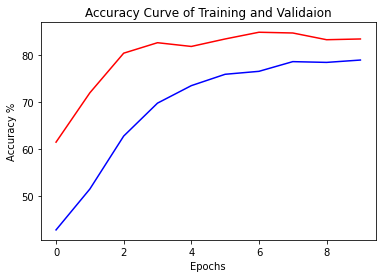

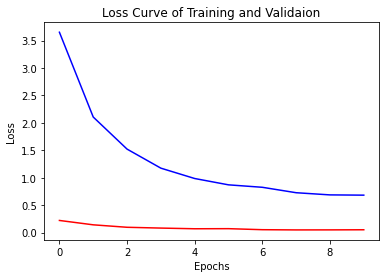

(3, 3)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


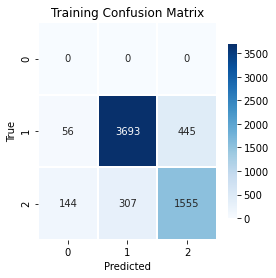

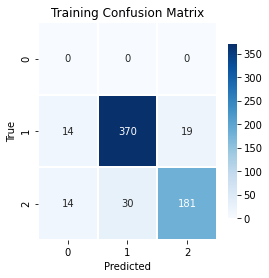

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  vgg16.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # 
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    label=labels
    labels= torch.nn.functional.one_hot(labels, len(class_names))
    for i in range(labels[:,0].shape[0]):
      if(labels[:,0][i]==1):
        labels[:,2][i]=1

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = vgg16(inputs)               #----> forward pass
    # _, predict = torch.max(outputs.data, 1)
  
    loss = criterion(outputs, labels.float())   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    
    limit = Variable(torch.Tensor([0.50])).to(device)
    # # print("Before",outputs)
    # # outputs=torch.Sigmoid(outputs)
    # o=outputs.cpu()
    # o=o.detach().numpy()
    # outputs = 1/(1 + np.exp(-o))
    # # print("Afterr",outputs)
    
    predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    # print("labeleddd", labels)
    # print("outputedd",outputs)
    # print("predicted", predicted)
    
    # total_correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    total_correct += get_num_correct(predicted, labels)
    
    predicted= predicted.cpu().numpy()
    outputs= outputs.cpu().detach().numpy()
    # print("After",predicted)

    for i in range(outputs.shape[0]):
      
      
      
      if (predicted[i]==[1,0,1]).all():
        train_p.extend([0])
        counter+=1
      elif (predicted[i]==[0,1,0]).all():
        train_p.extend([1])
      elif (predicted[i]==[0,0,1]).all():
         train_p.extend([2])
      else:
          l=outputs[i].argmax(axis=0)
          # print("Predicted",predicted[i])
          # print("label:",l)
          train_p.extend([l])

        



    # train_p.extend(predicted)
    train_l.extend(label.cpu().numpy())

    # print("train predicted",train_p)
    
    # print("train label",train_l)

    pbar.set_description(
        
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss,"counter:",counter)
  torch.save(vgg16,"vgg16_focal_loss.pth")

  vgg16.eval()
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import multilabel_confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  counter=0
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          label=labels
          labels= torch.nn.functional.one_hot(labels, len(class_names))
          for i in range(labels[:,0].shape[0]):
            if(labels[:,0][i]==1):
              labels[:,2][i]=1


          outputs = vgg16(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)

          limit = Variable(torch.Tensor([0.50])).to(device)
          predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    

          loss = criterion(outputs, labels.float())

          correct += get_num_correct(predicted, labels)
          # print("Predicted",predicted)
          # print("Labels",labels)
          
          running_loss += loss.item()
          predicted= predicted.cpu().numpy()
          outputs=outputs.cpu().detach().numpy()

          for i in range(outputs.shape[0]):
            
            
            
            if (predicted[i]==[1,0,1]).all():
              valid_p.extend([0])
              counter+=1
            elif (predicted[i]==[0,1,0]).all():
              valid_p.extend([1])
            elif (predicted[i]==[0,0,1]).all():
              valid_p.extend([2])              # labels[:,2][i]=1
            else:
              l=outputs[i].argmax(axis=0)
              # print("Predicted",predicted[i])
              # print("label:",l)
              valid_p.extend([l])
              
              
            
          # valid_p.extend(predicted)
          valid_l.extend(label.cpu().numpy())
          # print(".",correct)
  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss,"counter:",counter)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)
print(train_input.shape)
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

# **Training Loop (Alpha=2, Gamma=1, LR=0.001)**

In [0]:
def get_num_correct(preds, labs):
    # return preds.argmax(dim=1).eq(labels).sum().item()
    return torch.sum(torch.all(torch.eq(preds, labs),dim=1)).item()
# vg.train(mode=True)

Epochs = 10
# criterion = nn.BCEWithLogitsLoss()
criterion=FocalLoss(alpha=2,gamma=1)
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

Train Epoch: 0 [3080/6200 (57%)]	Loss: 0.145145: : 97it [02:09,  1.33s/it]


Train: epoch:  0 total_correct:  3530.0 total_loss:  25.185000203549862 counter: 0
Valid: epoch:  0 total_correct:  519 total_loss:  1.0668374598026276 counter: 0
 


Train Epoch: 1 [3080/6200 (57%)]	Loss: 0.107147: : 97it [02:09,  1.34s/it]


Train: epoch:  1 total_correct:  4895.0 total_loss:  11.586661508306861 counter: 0
Valid: epoch:  1 total_correct:  543 total_loss:  0.717837281525135 counter: 0
 


Train Epoch: 2 [3080/6200 (57%)]	Loss: 0.066184: : 97it [02:10,  1.35s/it]


Train: epoch:  2 total_correct:  5055.0 total_loss:  9.622023805975914 counter: 0
Valid: epoch:  2 total_correct:  538 total_loss:  0.705278730019927 counter: 0
 


Train Epoch: 3 [3080/6200 (57%)]	Loss: 0.104974: : 97it [02:10,  1.35s/it]


Train: epoch:  3 total_correct:  5124.0 total_loss:  8.40405127685517 counter: 0
Valid: epoch:  3 total_correct:  552 total_loss:  0.7501387130469084 counter: 0
 


Train Epoch: 4 [3080/6200 (57%)]	Loss: 0.163130: : 97it [02:10,  1.35s/it]


Train: epoch:  4 total_correct:  5167.0 total_loss:  8.319888655096292 counter: 3
Valid: epoch:  4 total_correct:  520 total_loss:  0.7821642868220806 counter: 0
 


Train Epoch: 5 [3080/6200 (57%)]	Loss: 0.049363: : 97it [02:10,  1.35s/it]


Train: epoch:  5 total_correct:  5189.0 total_loss:  7.538162676617503 counter: 9
Valid: epoch:  5 total_correct:  557 total_loss:  0.5021617766469717 counter: 1
 


Train Epoch: 6 [3080/6200 (57%)]	Loss: 0.053687: : 97it [02:11,  1.35s/it]


Train: epoch:  6 total_correct:  5237.0 total_loss:  6.8053287621587515 counter: 23
Valid: epoch:  6 total_correct:  551 total_loss:  0.4865808431059122 counter: 3
 


Train Epoch: 7 [3080/6200 (57%)]	Loss: 0.018662: : 97it [02:11,  1.35s/it]


Train: epoch:  7 total_correct:  5263.0 total_loss:  6.818116029724479 counter: 35
Valid: epoch:  7 total_correct:  534 total_loss:  0.5674970429390669 counter: 3
 


Train Epoch: 8 [3080/6200 (57%)]	Loss: 0.029120: : 97it [02:12,  1.37s/it]


Train: epoch:  8 total_correct:  5240.0 total_loss:  7.027496087364852 counter: 26
Valid: epoch:  8 total_correct:  545 total_loss:  0.5128820613026619 counter: 5
 


Train Epoch: 9 [3080/6200 (57%)]	Loss: 0.071832: : 97it [02:13,  1.37s/it]


Train: epoch:  9 total_correct:  5271.0 total_loss:  6.346218368038535 counter: 30
Valid: epoch:  9 total_correct:  553 total_loss:  0.4279850162565708 counter: 5
 
Training Accuracy 85.01612903225806 %
Validation Accuracy 88.05732484076434 %
Finished Training


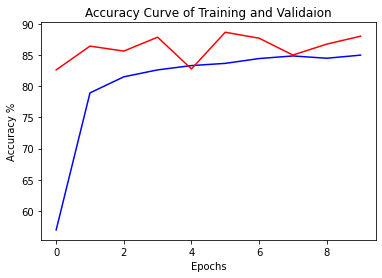

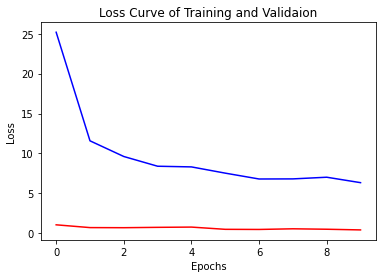

(3, 3)


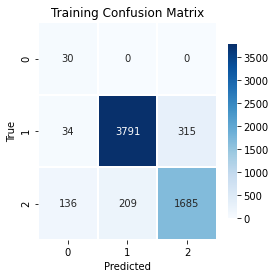

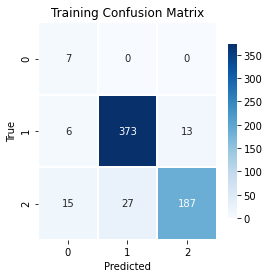

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  vgg16.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # 
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    label=labels
    labels= torch.nn.functional.one_hot(labels, len(class_names))
    for i in range(labels[:,0].shape[0]):
      if(labels[:,0][i]==1):
        labels[:,2][i]=1

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = vgg16(inputs)               #----> forward pass
    # _, predict = torch.max(outputs.data, 1)
  
    loss = criterion(outputs, labels.float())   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    
    limit = Variable(torch.Tensor([0.50])).to(device)
    # # print("Before",outputs)
    # # outputs=torch.Sigmoid(outputs)
    # o=outputs.cpu()
    # o=o.detach().numpy()
    # outputs = 1/(1 + np.exp(-o))
    # # print("Afterr",outputs)
    
    predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    # print("labeleddd", labels)
    # print("outputedd",outputs)
    # print("predicted", predicted)
    
    # total_correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    total_correct += get_num_correct(predicted, labels)
    
    predicted= predicted.cpu().numpy()
    outputs= outputs.cpu().detach().numpy()
    # print("After",predicted)

    for i in range(outputs.shape[0]):
      
      
      
      if (predicted[i]==[1,0,1]).all():
        train_p.extend([0])
        counter+=1
      elif (predicted[i]==[0,1,0]).all():
        train_p.extend([1])
      elif (predicted[i]==[0,0,1]).all():
         train_p.extend([2])
      else:
          l=outputs[i].argmax(axis=0)
          # print("Predicted",predicted[i])
          # print("label:",l)
          train_p.extend([l])

        



    # train_p.extend(predicted)
    train_l.extend(label.cpu().numpy())

    # print("train predicted",train_p)
    
    # print("train label",train_l)

    pbar.set_description(
        
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss,"counter:",counter)
  torch.save(vgg16,"vgg16_focal_loss_exp2.pth")

  vgg16.eval()
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import multilabel_confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  counter=0
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          label=labels
          labels= torch.nn.functional.one_hot(labels, len(class_names))
          for i in range(labels[:,0].shape[0]):
            if(labels[:,0][i]==1):
              labels[:,2][i]=1


          outputs = vgg16(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)

          limit = Variable(torch.Tensor([0.50])).to(device)
          predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    

          loss = criterion(outputs, labels.float())

          correct += get_num_correct(predicted, labels)
          # print("Predicted",predicted)
          # print("Labels",labels)
          
          running_loss += loss.item()
          predicted= predicted.cpu().numpy()
          outputs=outputs.cpu().detach().numpy()

          for i in range(outputs.shape[0]):
            
            
            
            if (predicted[i]==[1,0,1]).all():
              valid_p.extend([0])
              counter+=1
            elif (predicted[i]==[0,1,0]).all():
              valid_p.extend([1])
            elif (predicted[i]==[0,0,1]).all():
              valid_p.extend([2])              # labels[:,2][i]=1
            else:
              l=outputs[i].argmax(axis=0)
              # print("Predicted",predicted[i])
              # print("label:",l)
              valid_p.extend([l])
              
              
            
          # valid_p.extend(predicted)
          valid_l.extend(label.cpu().numpy())
          # print(".",correct)
  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss,"counter:",counter)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)
print(train_input.shape)
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

# **Training Loop (Alpha=2, Gamma=1, LR=0.01)**

In [0]:
def get_num_correct(preds, labs):
    # return preds.argmax(dim=1).eq(labels).sum().item()
    return torch.sum(torch.all(torch.eq(preds, labs),dim=1)).item()
# vg.train(mode=True)

Epochs = 10
# criterion = nn.BCEWithLogitsLoss()
criterion=FocalLoss(alpha=2,gamma=1)
optimizer = optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9)

Train Epoch: 0 [3080/6200 (57%)]	Loss: 0.037402: : 97it [02:12,  1.36s/it]


Train: epoch:  0 total_correct:  4260.0 total_loss:  19.009756237268448 counter: 0
Valid: epoch:  0 total_correct:  540 total_loss:  1.2431988567113876 counter: 0
 


Train Epoch: 1 [3080/6200 (57%)]	Loss: 0.153037: : 97it [02:13,  1.38s/it]


Train: epoch:  1 total_correct:  5104.0 total_loss:  9.548016725108027 counter: 5
Valid: epoch:  1 total_correct:  528 total_loss:  0.8797258511185646 counter: 0
 


Train Epoch: 2 [3080/6200 (57%)]	Loss: 0.085480: : 97it [02:13,  1.37s/it]


Train: epoch:  2 total_correct:  5102.0 total_loss:  9.834616054780781 counter: 1
Valid: epoch:  2 total_correct:  529 total_loss:  0.9840416833758354 counter: 0
 


Train Epoch: 3 [3080/6200 (57%)]	Loss: 0.063607: : 97it [02:12,  1.37s/it]


Train: epoch:  3 total_correct:  5149.0 total_loss:  9.225249823182821 counter: 22
Valid: epoch:  3 total_correct:  559 total_loss:  0.48178263381123543 counter: 2
 


Train Epoch: 4 [3080/6200 (57%)]	Loss: 0.067376: : 97it [02:11,  1.36s/it]


Train: epoch:  4 total_correct:  5276.0 total_loss:  6.954230858944356 counter: 24
Valid: epoch:  4 total_correct:  541 total_loss:  0.4956520739942789 counter: 6
 


Train Epoch: 5 [3080/6200 (57%)]	Loss: 0.041203: : 97it [02:12,  1.36s/it]


Train: epoch:  5 total_correct:  5315.0 total_loss:  6.58351138047874 counter: 37
Valid: epoch:  5 total_correct:  569 total_loss:  0.506418002769351 counter: 4
 


Train Epoch: 6 [3080/6200 (57%)]	Loss: 0.063290: : 97it [02:13,  1.38s/it]


Train: epoch:  6 total_correct:  5350.0 total_loss:  6.151428954675794 counter: 52
Valid: epoch:  6 total_correct:  572 total_loss:  0.34822316747158766 counter: 7
 


Train Epoch: 7 [3080/6200 (57%)]	Loss: 0.045184: : 97it [02:13,  1.38s/it]


Train: epoch:  7 total_correct:  5285.0 total_loss:  7.048384111374617 counter: 56
Valid: epoch:  7 total_correct:  566 total_loss:  0.4022404383867979 counter: 3
 


Train Epoch: 8 [3080/6200 (57%)]	Loss: 0.045314: : 97it [02:13,  1.38s/it]


Train: epoch:  8 total_correct:  5315.0 total_loss:  6.309671229682863 counter: 48
Valid: epoch:  8 total_correct:  574 total_loss:  0.29444680362939835 counter: 11
 


Train Epoch: 9 [3080/6200 (57%)]	Loss: 0.131062: : 97it [02:13,  1.38s/it]


Train: epoch:  9 total_correct:  5396.0 total_loss:  5.77163156773895 counter: 61
Valid: epoch:  9 total_correct:  558 total_loss:  0.37640067748725414 counter: 13
 
Training Accuracy 87.03225806451613 %
Validation Accuracy 88.85350318471338 %
Finished Training


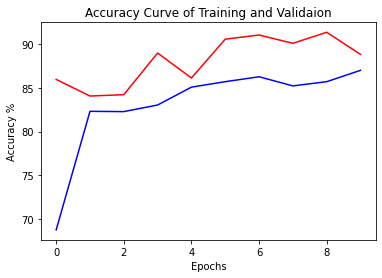

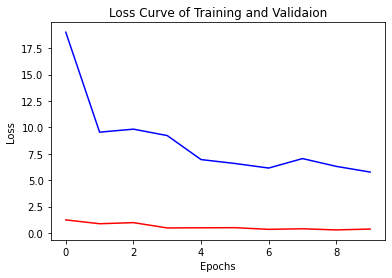

(3, 3)


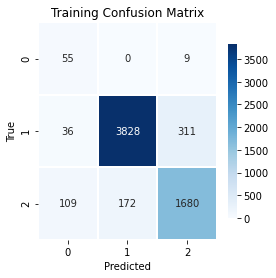

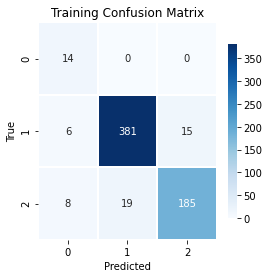

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  vgg16.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # 
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    label=labels
    labels= torch.nn.functional.one_hot(labels, len(class_names))
    for i in range(labels[:,0].shape[0]):
      if(labels[:,0][i]==1):
        labels[:,2][i]=1

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = vgg16(inputs)               #----> forward pass
    # _, predict = torch.max(outputs.data, 1)
  
    loss = criterion(outputs, labels.float())   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    
    limit = Variable(torch.Tensor([0.50])).to(device)
    # # print("Before",outputs)
    # # outputs=torch.Sigmoid(outputs)
    # o=outputs.cpu()
    # o=o.detach().numpy()
    # outputs = 1/(1 + np.exp(-o))
    # # print("Afterr",outputs)
    
    predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    # print("labeleddd", labels)
    # print("outputedd",outputs)
    # print("predicted", predicted)
    
    # total_correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    total_correct += get_num_correct(predicted, labels)
    
    predicted= predicted.cpu().numpy()
    outputs= outputs.cpu().detach().numpy()
    # print("After",predicted)

    for i in range(outputs.shape[0]):
      
      
      
      if (predicted[i]==[1,0,1]).all():
        train_p.extend([0])
        counter+=1
      elif (predicted[i]==[0,1,0]).all():
        train_p.extend([1])
      elif (predicted[i]==[0,0,1]).all():
         train_p.extend([2])
      else:
          l=outputs[i].argmax(axis=0)
          # print("Predicted",predicted[i])
          # print("label:",l)
          train_p.extend([l])

        



    # train_p.extend(predicted)
    train_l.extend(label.cpu().numpy())

    # print("train predicted",train_p)
    
    # print("train label",train_l)

    pbar.set_description(
        
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss,"counter:",counter)
  torch.save(vgg16,"vgg16_focal_loss_exp3.pth")

  vgg16.eval()
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import multilabel_confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  counter=0
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          label=labels
          labels= torch.nn.functional.one_hot(labels, len(class_names))
          for i in range(labels[:,0].shape[0]):
            if(labels[:,0][i]==1):
              labels[:,2][i]=1


          outputs = vgg16(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)

          limit = Variable(torch.Tensor([0.50])).to(device)
          predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    

          loss = criterion(outputs, labels.float())

          correct += get_num_correct(predicted, labels)
          # print("Predicted",predicted)
          # print("Labels",labels)
          
          running_loss += loss.item()
          predicted= predicted.cpu().numpy()
          outputs=outputs.cpu().detach().numpy()

          for i in range(outputs.shape[0]):
            
            
            
            if (predicted[i]==[1,0,1]).all():
              valid_p.extend([0])
              counter+=1
            elif (predicted[i]==[0,1,0]).all():
              valid_p.extend([1])
            elif (predicted[i]==[0,0,1]).all():
              valid_p.extend([2])              # labels[:,2][i]=1
            else:
              l=outputs[i].argmax(axis=0)
              # print("Predicted",predicted[i])
              # print("label:",l)
              valid_p.extend([l])
              
              
            
          # valid_p.extend(predicted)
          valid_l.extend(label.cpu().numpy())
          # print(".",correct)
  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss,"counter:",counter)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)
print(train_input.shape)
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

# **Training Loop (Alpha=1.5, Gamma=1, LR=0.001)**

In [0]:
def get_num_correct(preds, labs):
    # return preds.argmax(dim=1).eq(labels).sum().item()
    return torch.sum(torch.all(torch.eq(preds, labs),dim=1)).item()
# vg.train(mode=True)

Epochs = 10
# criterion = nn.BCEWithLogitsLoss()
criterion=FocalLoss(alpha=1.5,gamma=1)
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

Train Epoch: 0 [3080/6200 (57%)]	Loss: 0.195606: : 97it [02:10,  1.34s/it]


Train: epoch:  0 total_correct:  3520.0 total_loss:  19.138810731470585 counter: 0
Valid: epoch:  0 total_correct:  525 total_loss:  1.0173406302928925 counter: 0
 


Train Epoch: 1 [3080/6200 (57%)]	Loss: 0.140383: : 97it [02:11,  1.35s/it]


Train: epoch:  1 total_correct:  4765.0 total_loss:  9.915371723473072 counter: 0
Valid: epoch:  1 total_correct:  521 total_loss:  0.7094324864447117 counter: 0
 


Train Epoch: 2 [3080/6200 (57%)]	Loss: 0.035695: : 97it [02:12,  1.36s/it]


Train: epoch:  2 total_correct:  4977.0 total_loss:  7.536221543326974 counter: 0
Valid: epoch:  2 total_correct:  547 total_loss:  0.6745137637481093 counter: 0
 


Train Epoch: 3 [3080/6200 (57%)]	Loss: 0.087097: : 97it [02:12,  1.37s/it]


Train: epoch:  3 total_correct:  5023.0 total_loss:  7.452760277315974 counter: 0
Valid: epoch:  3 total_correct:  545 total_loss:  0.4854122158139944 counter: 0
 


Train Epoch: 4 [3080/6200 (57%)]	Loss: 0.084935: : 97it [02:13,  1.38s/it]


Train: epoch:  4 total_correct:  5134.0 total_loss:  6.153457622975111 counter: 2
Valid: epoch:  4 total_correct:  533 total_loss:  0.4941071346402168 counter: 0
 


Train Epoch: 5 [3080/6200 (57%)]	Loss: 0.015753: : 97it [02:12,  1.36s/it]


Train: epoch:  5 total_correct:  5216.0 total_loss:  5.614418504759669 counter: 15
Valid: epoch:  5 total_correct:  555 total_loss:  0.3882669508457184 counter: 0
 


Train Epoch: 6 [3080/6200 (57%)]	Loss: 0.081040: : 97it [02:14,  1.39s/it]


Train: epoch:  6 total_correct:  5151.0 total_loss:  5.997292107902467 counter: 19
Valid: epoch:  6 total_correct:  554 total_loss:  0.46540094166994095 counter: 1
 


Train Epoch: 7 [3080/6200 (57%)]	Loss: 0.030532: : 97it [02:14,  1.38s/it]


Train: epoch:  7 total_correct:  5195.0 total_loss:  5.717656311579049 counter: 18
Valid: epoch:  7 total_correct:  557 total_loss:  0.39510859176516533 counter: 1
 


Train Epoch: 8 [3080/6200 (57%)]	Loss: 0.044159: : 97it [02:15,  1.40s/it]


Train: epoch:  8 total_correct:  5283.0 total_loss:  4.8211336294189095 counter: 34
Valid: epoch:  8 total_correct:  561 total_loss:  0.3681146786548197 counter: 2
 


Train Epoch: 9 [3080/6200 (57%)]	Loss: 0.033285: : 97it [02:12,  1.36s/it]


Train: epoch:  9 total_correct:  5313.0 total_loss:  4.876353065948933 counter: 47
Valid: epoch:  9 total_correct:  552 total_loss:  0.32357396744191647 counter: 7
 
Training Accuracy 85.69354838709677 %
Validation Accuracy 87.89808917197452 %
Finished Training


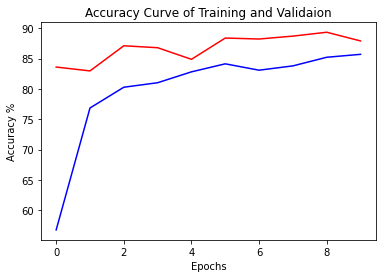

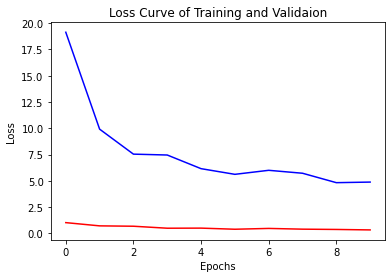

(3, 3)


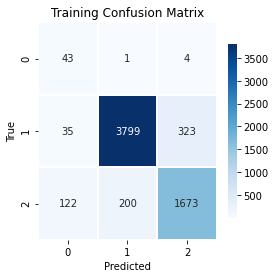

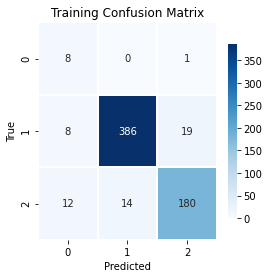

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  vgg16.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # 
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    label=labels
    labels= torch.nn.functional.one_hot(labels, len(class_names))
    for i in range(labels[:,0].shape[0]):
      if(labels[:,0][i]==1):
        labels[:,2][i]=1

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = vgg16(inputs)               #----> forward pass
    # _, predict = torch.max(outputs.data, 1)
  
    loss = criterion(outputs, labels.float())   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    
    limit = Variable(torch.Tensor([0.50])).to(device)
    # # print("Before",outputs)
    # # outputs=torch.Sigmoid(outputs)
    # o=outputs.cpu()
    # o=o.detach().numpy()
    # outputs = 1/(1 + np.exp(-o))
    # # print("Afterr",outputs)
    
    predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    # print("labeleddd", labels)
    # print("outputedd",outputs)
    # print("predicted", predicted)
    
    # total_correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    total_correct += get_num_correct(predicted, labels)
    
    predicted= predicted.cpu().numpy()
    outputs= outputs.cpu().detach().numpy()
    # print("After",predicted)

    for i in range(outputs.shape[0]):
      
      
      
      if (predicted[i]==[1,0,1]).all():
        train_p.extend([0])
        counter+=1
      elif (predicted[i]==[0,1,0]).all():
        train_p.extend([1])
      elif (predicted[i]==[0,0,1]).all():
         train_p.extend([2])
      else:
          l=outputs[i].argmax(axis=0)
          # print("Predicted",predicted[i])
          # print("label:",l)
          train_p.extend([l])

        



    # train_p.extend(predicted)
    train_l.extend(label.cpu().numpy())

    # print("train predicted",train_p)
    
    # print("train label",train_l)

    pbar.set_description(
        
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss,"counter:",counter)
  torch.save(vgg16,"vgg16_focal_loss_exp4.pth")

  vgg16.eval()
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import multilabel_confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  counter=0
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          label=labels
          labels= torch.nn.functional.one_hot(labels, len(class_names))
          for i in range(labels[:,0].shape[0]):
            if(labels[:,0][i]==1):
              labels[:,2][i]=1


          outputs = vgg16(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)

          limit = Variable(torch.Tensor([0.50])).to(device)
          predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    

          loss = criterion(outputs, labels.float())

          correct += get_num_correct(predicted, labels)
          # print("Predicted",predicted)
          # print("Labels",labels)
          
          running_loss += loss.item()
          predicted= predicted.cpu().numpy()
          outputs=outputs.cpu().detach().numpy()

          for i in range(outputs.shape[0]):
            
            
            
            if (predicted[i]==[1,0,1]).all():
              valid_p.extend([0])
              counter+=1
            elif (predicted[i]==[0,1,0]).all():
              valid_p.extend([1])
            elif (predicted[i]==[0,0,1]).all():
              valid_p.extend([2])              # labels[:,2][i]=1
            else:
              l=outputs[i].argmax(axis=0)
              # print("Predicted",predicted[i])
              # print("label:",l)
              valid_p.extend([l])
              
              
            
          # valid_p.extend(predicted)
          valid_l.extend(label.cpu().numpy())
          # print(".",correct)
  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss,"counter:",counter)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)
print(train_input.shape)
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

# **Training Loop (Alpha=1.5, Gamma=0.5, LR=0.001) BEST MODEL o_o**

In [0]:
def get_num_correct(preds, labs):
    # return preds.argmax(dim=1).eq(labels).sum().item()
    return torch.sum(torch.all(torch.eq(preds, labs),dim=1)).item()
# vg.train(mode=True)

Epochs = 10
# criterion = nn.BCEWithLogitsLoss()
criterion=FocalLoss(alpha=1.5,gamma=0.5)
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

Train Epoch: 0 [3080/6200 (57%)]	Loss: 0.211201: : 97it [02:12,  1.37s/it]


Train: epoch:  0 total_correct:  3598.0 total_loss:  31.981556713581085 counter: 0
Valid: epoch:  0 total_correct:  528 total_loss:  1.6665152944624424 counter: 0
 


Train Epoch: 1 [3080/6200 (57%)]	Loss: 0.167421: : 97it [02:14,  1.39s/it]


Train: epoch:  1 total_correct:  4889.0 total_loss:  17.709678575396538 counter: 0
Valid: epoch:  1 total_correct:  536 total_loss:  1.3511746674776077 counter: 0
 


Train Epoch: 2 [3080/6200 (57%)]	Loss: 0.176579: : 97it [02:13,  1.38s/it]


Train: epoch:  2 total_correct:  5127.0 total_loss:  14.845510147511959 counter: 0
Valid: epoch:  2 total_correct:  547 total_loss:  1.312354002147913 counter: 0
 


Train Epoch: 3 [3080/6200 (57%)]	Loss: 0.118084: : 97it [02:14,  1.39s/it]


Train: epoch:  3 total_correct:  5175.0 total_loss:  13.167984213680029 counter: 8
Valid: epoch:  3 total_correct:  543 total_loss:  0.9837053418159485 counter: 2
 


Train Epoch: 4 [3080/6200 (57%)]	Loss: 0.231988: : 97it [02:13,  1.38s/it]


Train: epoch:  4 total_correct:  5156.0 total_loss:  13.296700287610292 counter: 17
Valid: epoch:  4 total_correct:  507 total_loss:  1.433261413127184 counter: 4
 


Train Epoch: 5 [3080/6200 (57%)]	Loss: 0.113551: : 97it [02:14,  1.39s/it]


Train: epoch:  5 total_correct:  5261.0 total_loss:  12.043984157964587 counter: 39
Valid: epoch:  5 total_correct:  542 total_loss:  0.9952655397355556 counter: 6
 


Train Epoch: 6 [3080/6200 (57%)]	Loss: 0.099044: : 97it [02:11,  1.35s/it]


Train: epoch:  6 total_correct:  5280.0 total_loss:  11.354484029114246 counter: 33
Valid: epoch:  6 total_correct:  539 total_loss:  1.0353027433156967 counter: 14
 


Train Epoch: 7 [3080/6200 (57%)]	Loss: 0.132071: : 97it [02:10,  1.35s/it]


Train: epoch:  7 total_correct:  5303.0 total_loss:  10.963461820036173 counter: 60
Valid: epoch:  7 total_correct:  558 total_loss:  0.7911246567964554 counter: 7
 


Train Epoch: 8 [3080/6200 (57%)]	Loss: 0.071472: : 97it [02:10,  1.35s/it]


Train: epoch:  8 total_correct:  5336.0 total_loss:  10.723053384572268 counter: 66
Valid: epoch:  8 total_correct:  558 total_loss:  0.8087869323790073 counter: 15
 


Train Epoch: 9 [3080/6200 (57%)]	Loss: 0.069453: : 97it [02:10,  1.34s/it]


Train: epoch:  9 total_correct:  5361.0 total_loss:  10.318819146603346 counter: 75
Valid: epoch:  9 total_correct:  559 total_loss:  0.7657031118869781 counter: 15
 
Training Accuracy 86.46774193548387 %
Validation Accuracy 89.01273885350318 %
Finished Training


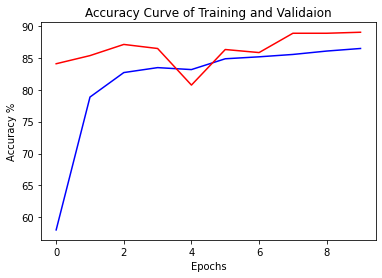

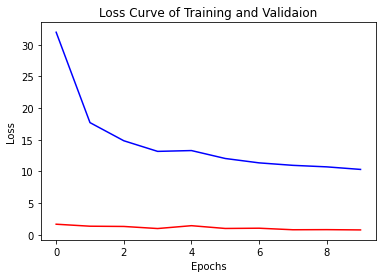

(3, 3)


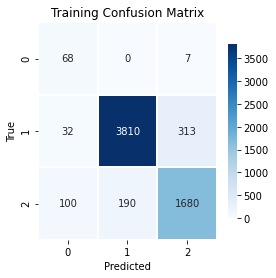

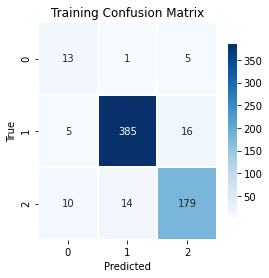

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  vgg16.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # 
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    label=labels
    labels= torch.nn.functional.one_hot(labels, len(class_names))
    for i in range(labels[:,0].shape[0]):
      if(labels[:,0][i]==1):
        labels[:,2][i]=1

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = vgg16(inputs)               #----> forward pass
    # _, predict = torch.max(outputs.data, 1)
  
    loss = criterion(outputs, labels.float())   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    
    limit = Variable(torch.Tensor([0.50])).to(device)
    # # print("Before",outputs)
    # # outputs=torch.Sigmoid(outputs)
    # o=outputs.cpu()
    # o=o.detach().numpy()
    # outputs = 1/(1 + np.exp(-o))
    # # print("Afterr",outputs)
    
    predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    # print("labeleddd", labels)
    # print("outputedd",outputs)
    # print("predicted", predicted)
    
    # total_correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    total_correct += get_num_correct(predicted, labels)
    
    predicted= predicted.cpu().numpy()
    outputs= outputs.cpu().detach().numpy()
    # print("After",predicted)

    for i in range(outputs.shape[0]):
      
      
      
      if (predicted[i]==[1,0,1]).all():
        train_p.extend([0])
        counter+=1
      elif (predicted[i]==[0,1,0]).all():
        train_p.extend([1])
      elif (predicted[i]==[0,0,1]).all():
         train_p.extend([2])
      else:
          l=outputs[i].argmax(axis=0)
          # print("Predicted",predicted[i])
          # print("label:",l)
          train_p.extend([l])

        



    # train_p.extend(predicted)
    train_l.extend(label.cpu().numpy())

    # print("train predicted",train_p)
    
    # print("train label",train_l)

    pbar.set_description(
        
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss,"counter:",counter)
  torch.save(vgg16,"vgg16_focal_loss_exp5.pth")

  vgg16.eval()
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import multilabel_confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  counter=0
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          label=labels
          labels= torch.nn.functional.one_hot(labels, len(class_names))
          for i in range(labels[:,0].shape[0]):
            if(labels[:,0][i]==1):
              labels[:,2][i]=1


          outputs = vgg16(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)

          limit = Variable(torch.Tensor([0.50])).to(device)
          predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    

          loss = criterion(outputs, labels.float())

          correct += get_num_correct(predicted, labels)
          # print("Predicted",predicted)
          # print("Labels",labels)
          
          running_loss += loss.item()
          predicted= predicted.cpu().numpy()
          outputs=outputs.cpu().detach().numpy()

          for i in range(outputs.shape[0]):
            
            
            
            if (predicted[i]==[1,0,1]).all():
              valid_p.extend([0])
              counter+=1
            elif (predicted[i]==[0,1,0]).all():
              valid_p.extend([1])
            elif (predicted[i]==[0,0,1]).all():
              valid_p.extend([2])              # labels[:,2][i]=1
            else:
              l=outputs[i].argmax(axis=0)
              # print("Predicted",predicted[i])
              # print("label:",l)
              valid_p.extend([l])
              
              
            
          # valid_p.extend(predicted)
          valid_l.extend(label.cpu().numpy())
          # print(".",correct)
  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss,"counter:",counter)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)
print(train_input.shape)
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

Confusion Matrix repeat . . .

15
 
Validation Accuracy 89.01273885350318 %
Validation F1 Score : 0.9187898089171974


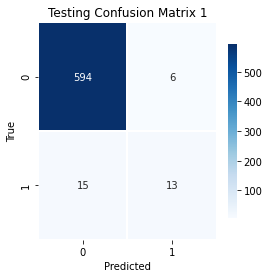

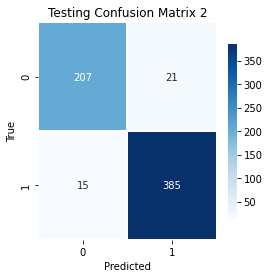

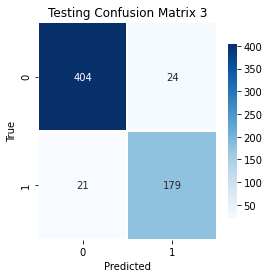

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score


vgg16=torch.load("vgg16_focal_loss_exp5.pth")
vgg16.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

correct = 0
total = 0

running_loss=0.0

valid_p=[]
valid_l=[]
counter=0
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        label=labels
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        for i in range(labels[:,0].shape[0]):
          if(labels[:,0][i]==1):
            labels[:,2][i]=1


        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        limit = Variable(torch.Tensor([0.50])).to(device)
        predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
  

        loss = criterion(outputs, labels.float())

        correct += get_num_correct(predicted, labels)
        # print("Predicted",predicted)
        # print("Labels",labels)
        
        running_loss += loss.item()
        predicted= predicted.cpu().numpy()
        outputs=outputs.cpu().detach().numpy()

        for i in range(outputs.shape[0]):
          
          
          
          if (predicted[i]==[1,0,1]).all():
            valid_p.extend([0])
            counter+=1
          elif (predicted[i]==[0,1,0]).all():
            valid_p.extend([1])
          elif (predicted[i]==[0,0,1]).all():
            valid_p.extend([2])              # labels[:,2][i]=1
          else:
            l=outputs[i].argmax(axis=0)
            # print("Predicted",predicted[i])
            # print("label:",l)
            valid_p.extend([l])
            
            
          
        # valid_p.extend(predicted)
        valid_l.extend(label.cpu().numpy())
        # print(".",correct)
# valid_acc.append((100 * correct) / total)
# valid_loss.append(running_loss)
print(counter)
print(" ")


print("Validation Accuracy",((100 * correct) / total),"%")
print("Validation F1 Score :",f1_score(valid_l, valid_p, average="micro")) # p are predicted labels and l are true labels

valid_input=multilabel_confusion_matrix(valid_l,valid_p)

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input[0],cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix 1")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input[1],cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix 2")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input[2],cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix 3")
plt.show()


# f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="micro"))

# **Training Loop (Alpha=1.5, Gamma=0.25, LR=0.001)**

In [0]:
def get_num_correct(preds, labs):
    # return preds.argmax(dim=1).eq(labels).sum().item()
    return torch.sum(torch.all(torch.eq(preds, labs),dim=1)).item()
# vg.train(mode=True)

Epochs = 10
# criterion = nn.BCEWithLogitsLoss()
criterion=FocalLoss(alpha=1.5,gamma=0.25)
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

Train Epoch: 0 [3080/6200 (57%)]	Loss: 0.333238: : 97it [02:12,  1.36s/it]


Train: epoch:  0 total_correct:  3654.0 total_loss:  41.471876472234726 counter: 0
Valid: epoch:  0 total_correct:  494 total_loss:  2.762574151158333 counter: 0
 


Train Epoch: 1 [3080/6200 (57%)]	Loss: 0.370002: : 97it [02:11,  1.35s/it]


Train: epoch:  1 total_correct:  4888.0 total_loss:  26.429952889680862 counter: 0
Valid: epoch:  1 total_correct:  542 total_loss:  2.6036321371793747 counter: 0
 


Train Epoch: 2 [3080/6200 (57%)]	Loss: 0.329480: : 97it [02:11,  1.35s/it]


Train: epoch:  2 total_correct:  5045.0 total_loss:  22.842524737119675 counter: 0
Valid: epoch:  2 total_correct:  542 total_loss:  1.6747563630342484 counter: 0
 


Train Epoch: 3 [3080/6200 (57%)]	Loss: 0.108072: : 97it [02:10,  1.35s/it]


Train: epoch:  3 total_correct:  5131.0 total_loss:  20.587353974580765 counter: 3
Valid: epoch:  3 total_correct:  557 total_loss:  1.7465588673949242 counter: 0
 


Train Epoch: 4 [3080/6200 (57%)]	Loss: 0.093797: : 97it [02:12,  1.37s/it]


Train: epoch:  4 total_correct:  5242.0 total_loss:  19.092892959713936 counter: 21
Valid: epoch:  4 total_correct:  536 total_loss:  1.6233857050538063 counter: 1
 


Train Epoch: 5 [3080/6200 (57%)]	Loss: 0.110585: : 97it [02:12,  1.36s/it]


Train: epoch:  5 total_correct:  5240.0 total_loss:  18.311412662267685 counter: 21
Valid: epoch:  5 total_correct:  527 total_loss:  1.7800201773643494 counter: 4
 


Train Epoch: 6 [3080/6200 (57%)]	Loss: 0.196446: : 97it [02:11,  1.36s/it]


Train: epoch:  6 total_correct:  5292.0 total_loss:  17.506322965025902 counter: 29
Valid: epoch:  6 total_correct:  538 total_loss:  1.504863291978836 counter: 3
 


Train Epoch: 7 [3080/6200 (57%)]	Loss: 0.179995: : 97it [02:12,  1.37s/it]


Train: epoch:  7 total_correct:  5347.0 total_loss:  16.754992712289095 counter: 44
Valid: epoch:  7 total_correct:  568 total_loss:  1.3161517605185509 counter: 4
 


Train Epoch: 8 [3080/6200 (57%)]	Loss: 0.083802: : 97it [02:12,  1.36s/it]


Train: epoch:  8 total_correct:  5307.0 total_loss:  17.19713169708848 counter: 40
Valid: epoch:  8 total_correct:  571 total_loss:  1.3339201658964157 counter: 5
 


Train Epoch: 9 [3080/6200 (57%)]	Loss: 0.183986: : 97it [02:10,  1.35s/it]


Train: epoch:  9 total_correct:  5278.0 total_loss:  17.718805715441704 counter: 59
Valid: epoch:  9 total_correct:  566 total_loss:  1.3465320244431496 counter: 6
 
Training Accuracy 85.12903225806451 %
Validation Accuracy 90.12738853503184 %
Finished Training


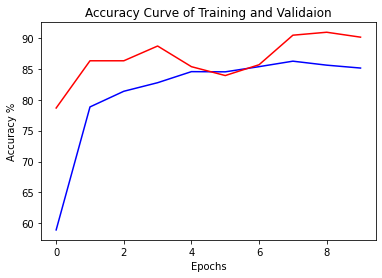

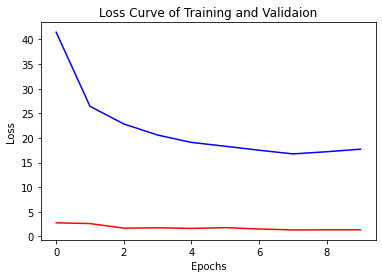

(3, 3)


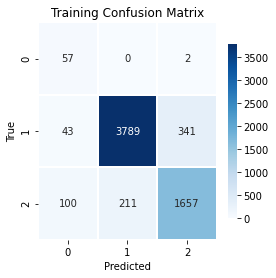

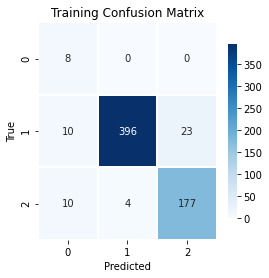

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  vgg16.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # 
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    label=labels
    labels= torch.nn.functional.one_hot(labels, len(class_names))
    for i in range(labels[:,0].shape[0]):
      if(labels[:,0][i]==1):
        labels[:,2][i]=1

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = vgg16(inputs)               #----> forward pass
    # _, predict = torch.max(outputs.data, 1)
  
    loss = criterion(outputs, labels.float())   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    
    limit = Variable(torch.Tensor([0.50])).to(device)
    # # print("Before",outputs)
    # # outputs=torch.Sigmoid(outputs)
    # o=outputs.cpu()
    # o=o.detach().numpy()
    # outputs = 1/(1 + np.exp(-o))
    # # print("Afterr",outputs)
    
    predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    # print("labeleddd", labels)
    # print("outputedd",outputs)
    # print("predicted", predicted)
    
    # total_correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    total_correct += get_num_correct(predicted, labels)
    
    predicted= predicted.cpu().numpy()
    outputs= outputs.cpu().detach().numpy()
    # print("After",predicted)

    for i in range(outputs.shape[0]):
      
      
      
      if (predicted[i]==[1,0,1]).all():
        train_p.extend([0])
        counter+=1
      elif (predicted[i]==[0,1,0]).all():
        train_p.extend([1])
      elif (predicted[i]==[0,0,1]).all():
         train_p.extend([2])
      else:
          l=outputs[i].argmax(axis=0)
          # print("Predicted",predicted[i])
          # print("label:",l)
          train_p.extend([l])

        



    # train_p.extend(predicted)
    train_l.extend(label.cpu().numpy())

    # print("train predicted",train_p)
    
    # print("train label",train_l)

    pbar.set_description(
        
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss,"counter:",counter)
  torch.save(vgg16,"vgg16_focal_loss_exp6.pth")

  vgg16.eval()
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import multilabel_confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  counter=0
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          label=labels
          labels= torch.nn.functional.one_hot(labels, len(class_names))
          for i in range(labels[:,0].shape[0]):
            if(labels[:,0][i]==1):
              labels[:,2][i]=1


          outputs = vgg16(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)

          limit = Variable(torch.Tensor([0.50])).to(device)
          predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    

          loss = criterion(outputs, labels.float())

          correct += get_num_correct(predicted, labels)
          # print("Predicted",predicted)
          # print("Labels",labels)
          
          running_loss += loss.item()
          predicted= predicted.cpu().numpy()
          outputs=outputs.cpu().detach().numpy()

          for i in range(outputs.shape[0]):
            
            
            
            if (predicted[i]==[1,0,1]).all():
              valid_p.extend([0])
              counter+=1
            elif (predicted[i]==[0,1,0]).all():
              valid_p.extend([1])
            elif (predicted[i]==[0,0,1]).all():
              valid_p.extend([2])              # labels[:,2][i]=1
            else:
              l=outputs[i].argmax(axis=0)
              # print("Predicted",predicted[i])
              # print("label:",l)
              valid_p.extend([l])
              
              
            
          # valid_p.extend(predicted)
          valid_l.extend(label.cpu().numpy())
          # print(".",correct)
  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss,"counter:",counter)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)
print(train_input.shape)
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

# **Training Loop (Alpha=1.5, Gamma=0.25, LR=0.01)**

In [0]:
def get_num_correct(preds, labs):
    # return preds.argmax(dim=1).eq(labels).sum().item()
    return torch.sum(torch.all(torch.eq(preds, labs),dim=1)).item()
# vg.train(mode=True)

Epochs = 10
# criterion = nn.BCEWithLogitsLoss()
criterion=FocalLoss(alpha=1.5,gamma=0.25)
optimizer = optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9)




0it [00:00, ?it/s]


Train Epoch: 0 [4032/6200 (65%)]	Loss: 0.825794: : 0it [00:06, ?it/s]


Train Epoch: 0 [4032/6200 (65%)]	Loss: 0.825794: : 1it [00:06,  6.15s/it]


Train Epoch: 0 [4032/6200 (65%)]	Loss: 0.654995: : 1it [00:07,  6.15s/it]


Train Epoch: 0 [4032/6200 (65%)]	Loss: 0.654995: : 2it [00:07,  4.66s/it]


Train Epoch: 0 [4032/6200 (65%)]	Loss: 0.504130: : 2it [00:08,  4.66s/it]


Train Epoch: 0 [4032/6200 (65%)]	Loss: 0.504130: : 3it [00:08,  3.62s/it]


Train Epoch: 0 [4032/6200 (65%)]	Loss: 0.730311: : 3it [00:09,  3.62s/it]


Train Epoch: 0 [4032/6200 (65%)]	Loss: 0.730311: : 4it [00:09,  2.88s/it]


Train Epoch: 0 [4032/6200 (65%)]	Loss: 0.537841: : 4it [00:12,  2.88s/it]


Train Epoch: 0 [4032/6200 (65%)]	Loss: 0.537841: : 5it [00:12,  2.81s/it]


Train Epoch: 0 [4032/6200 (65%)]	Loss: 0.610722: : 5it [00:13,  2.81s/it]


Train Epoch: 0 [4032/6200 (65%)]	Loss: 0.610722: : 6it [00:13,  2.33s/it]


Train Epoch: 0 [4032/6200 (65%)]	Loss: 0.469340: : 6it [00:14,  2.33

Train: epoch:  0 total_correct:  4154.0 total_loss:  37.26682996749878 counter: 0
Valid: epoch:  0 total_correct:  520 total_loss:  2.4556419402360916 counter: 0
 





0it [00:00, ?it/s]


Train Epoch: 1 [4032/6200 (65%)]	Loss: 0.265028: : 0it [00:06, ?it/s]


Train Epoch: 1 [4032/6200 (65%)]	Loss: 0.265028: : 1it [00:06,  6.78s/it]


Train Epoch: 1 [4032/6200 (65%)]	Loss: 0.308635: : 1it [00:08,  6.78s/it]


Train Epoch: 1 [4032/6200 (65%)]	Loss: 0.308635: : 2it [00:08,  5.21s/it]


Train Epoch: 1 [4032/6200 (65%)]	Loss: 0.354047: : 2it [00:09,  5.21s/it]


Train Epoch: 1 [4032/6200 (65%)]	Loss: 0.354047: : 3it [00:09,  4.02s/it]


Train Epoch: 1 [4032/6200 (65%)]	Loss: 0.276284: : 3it [00:10,  4.02s/it]


Train Epoch: 1 [4032/6200 (65%)]	Loss: 0.276284: : 4it [00:10,  3.17s/it]


Train Epoch: 1 [4032/6200 (65%)]	Loss: 0.394151: : 4it [00:13,  3.17s/it]


Train Epoch: 1 [4032/6200 (65%)]	Loss: 0.394151: : 5it [00:13,  3.13s/it]


Train Epoch: 1 [4032/6200 (65%)]	Loss: 0.299152: : 5it [00:14,  3.13s/it]


Train Epoch: 1 [4032/6200 (65%)]	Loss: 0.299152: : 6it [00:14,  2.55s/it]


Train Epoch: 1 [4032/6200 (65%)]	Loss: 0.338123: : 6it [00:16,  2.55

Train: epoch:  1 total_correct:  4842.0 total_loss:  28.08200380206108 counter: 0
Valid: epoch:  1 total_correct:  509 total_loss:  2.495307758450508 counter: 0
 





0it [00:00, ?it/s]


Train Epoch: 2 [4032/6200 (65%)]	Loss: 0.414067: : 0it [00:06, ?it/s]


Train Epoch: 2 [4032/6200 (65%)]	Loss: 0.414067: : 1it [00:06,  6.63s/it]


Train Epoch: 2 [4032/6200 (65%)]	Loss: 0.214891: : 1it [00:07,  6.63s/it]


Train Epoch: 2 [4032/6200 (65%)]	Loss: 0.214891: : 2it [00:07,  5.00s/it]


Train Epoch: 2 [4032/6200 (65%)]	Loss: 0.321941: : 2it [00:09,  5.00s/it]


Train Epoch: 2 [4032/6200 (65%)]	Loss: 0.321941: : 3it [00:09,  3.87s/it]


Train Epoch: 2 [4032/6200 (65%)]	Loss: 0.209735: : 3it [00:10,  3.87s/it]


Train Epoch: 2 [4032/6200 (65%)]	Loss: 0.209735: : 4it [00:10,  3.07s/it]


Train Epoch: 2 [4032/6200 (65%)]	Loss: 0.315654: : 4it [00:13,  3.07s/it]


Train Epoch: 2 [4032/6200 (65%)]	Loss: 0.315654: : 5it [00:13,  3.17s/it]


Train Epoch: 2 [4032/6200 (65%)]	Loss: 0.447234: : 5it [00:14,  3.17s/it]


Train Epoch: 2 [4032/6200 (65%)]	Loss: 0.447234: : 6it [00:14,  2.58s/it]


Train Epoch: 2 [4032/6200 (65%)]	Loss: 0.261380: : 6it [00:16,  2.58

Train: epoch:  2 total_correct:  4975.0 total_loss:  25.408166497945786 counter: 0
Valid: epoch:  2 total_correct:  553 total_loss:  1.5895811915397644 counter: 2
 





0it [00:00, ?it/s]


Train Epoch: 3 [4032/6200 (65%)]	Loss: 0.166587: : 0it [00:07, ?it/s]


Train Epoch: 3 [4032/6200 (65%)]	Loss: 0.166587: : 1it [00:07,  7.06s/it]


Train Epoch: 3 [4032/6200 (65%)]	Loss: 0.177978: : 1it [00:08,  7.06s/it]


Train Epoch: 3 [4032/6200 (65%)]	Loss: 0.177978: : 2it [00:08,  5.30s/it]


Train Epoch: 3 [4032/6200 (65%)]	Loss: 0.205575: : 2it [00:09,  5.30s/it]


Train Epoch: 3 [4032/6200 (65%)]	Loss: 0.205575: : 3it [00:09,  4.07s/it]


Train Epoch: 3 [4032/6200 (65%)]	Loss: 0.213460: : 3it [00:10,  4.07s/it]


Train Epoch: 3 [4032/6200 (65%)]	Loss: 0.213460: : 4it [00:10,  3.22s/it]


Train Epoch: 3 [4032/6200 (65%)]	Loss: 0.147455: : 4it [00:13,  3.22s/it]


Train Epoch: 3 [4032/6200 (65%)]	Loss: 0.147455: : 5it [00:13,  3.04s/it]


Train Epoch: 3 [4032/6200 (65%)]	Loss: 0.450221: : 5it [00:14,  3.04s/it]


Train Epoch: 3 [4032/6200 (65%)]	Loss: 0.450221: : 6it [00:14,  2.49s/it]


Train Epoch: 3 [4032/6200 (65%)]	Loss: 0.219161: : 6it [00:15,  2.49

Train: epoch:  3 total_correct:  5182.0 total_loss:  21.030652284622192 counter: 20
Valid: epoch:  3 total_correct:  548 total_loss:  2.216300070285797 counter: 0
 





0it [00:00, ?it/s]


Train Epoch: 4 [4032/6200 (65%)]	Loss: 0.329273: : 0it [00:07, ?it/s]


Train Epoch: 4 [4032/6200 (65%)]	Loss: 0.329273: : 1it [00:07,  7.13s/it]


Train Epoch: 4 [4032/6200 (65%)]	Loss: 0.183438: : 1it [00:08,  7.13s/it]


Train Epoch: 4 [4032/6200 (65%)]	Loss: 0.183438: : 2it [00:08,  5.36s/it]


Train Epoch: 4 [4032/6200 (65%)]	Loss: 0.330159: : 2it [00:09,  5.36s/it]


Train Epoch: 4 [4032/6200 (65%)]	Loss: 0.330159: : 3it [00:09,  4.12s/it]


Train Epoch: 4 [4032/6200 (65%)]	Loss: 0.314495: : 3it [00:10,  4.12s/it]


Train Epoch: 4 [4032/6200 (65%)]	Loss: 0.314495: : 4it [00:10,  3.25s/it]


Train Epoch: 4 [4032/6200 (65%)]	Loss: 0.254935: : 4it [00:13,  3.25s/it]


Train Epoch: 4 [4032/6200 (65%)]	Loss: 0.254935: : 5it [00:13,  3.04s/it]


Train Epoch: 4 [4032/6200 (65%)]	Loss: 0.219557: : 5it [00:14,  3.04s/it]


Train Epoch: 4 [4032/6200 (65%)]	Loss: 0.219557: : 6it [00:14,  2.48s/it]


Train Epoch: 4 [4032/6200 (65%)]	Loss: 0.328999: : 6it [00:15,  2.48

Train: epoch:  4 total_correct:  5144.0 total_loss:  21.195695839822292 counter: 15
Valid: epoch:  4 total_correct:  563 total_loss:  2.1142564490437508 counter: 7
 





0it [00:00, ?it/s]


Train Epoch: 5 [4032/6200 (65%)]	Loss: 0.344597: : 0it [00:06, ?it/s]


Train Epoch: 5 [4032/6200 (65%)]	Loss: 0.344597: : 1it [00:06,  6.63s/it]


Train Epoch: 5 [4032/6200 (65%)]	Loss: 0.137832: : 1it [00:07,  6.63s/it]


Train Epoch: 5 [4032/6200 (65%)]	Loss: 0.137832: : 2it [00:07,  5.00s/it]


Train Epoch: 5 [4032/6200 (65%)]	Loss: 0.111421: : 2it [00:09,  5.00s/it]


Train Epoch: 5 [4032/6200 (65%)]	Loss: 0.111421: : 3it [00:09,  3.87s/it]


Train Epoch: 5 [4032/6200 (65%)]	Loss: 0.168989: : 3it [00:10,  3.87s/it]


Train Epoch: 5 [4032/6200 (65%)]	Loss: 0.168989: : 4it [00:10,  3.07s/it]


Train Epoch: 5 [4032/6200 (65%)]	Loss: 0.316133: : 4it [00:13,  3.07s/it]


Train Epoch: 5 [4032/6200 (65%)]	Loss: 0.316133: : 5it [00:13,  3.22s/it]


Train Epoch: 5 [4032/6200 (65%)]	Loss: 0.207363: : 5it [00:15,  3.22s/it]


Train Epoch: 5 [4032/6200 (65%)]	Loss: 0.207363: : 6it [00:15,  2.63s/it]


Train Epoch: 5 [4032/6200 (65%)]	Loss: 0.199789: : 6it [00:16,  2.63

Train: epoch:  5 total_correct:  5246.0 total_loss:  19.596784725785255 counter: 48
Valid: epoch:  5 total_correct:  540 total_loss:  1.6469763219356537 counter: 2
 





0it [00:00, ?it/s]


Train Epoch: 6 [4032/6200 (65%)]	Loss: 0.274451: : 0it [00:06, ?it/s]


Train Epoch: 6 [4032/6200 (65%)]	Loss: 0.274451: : 1it [00:06,  6.33s/it]


Train Epoch: 6 [4032/6200 (65%)]	Loss: 0.219305: : 1it [00:07,  6.33s/it]


Train Epoch: 6 [4032/6200 (65%)]	Loss: 0.219305: : 2it [00:07,  4.80s/it]


Train Epoch: 6 [4032/6200 (65%)]	Loss: 0.106058: : 2it [00:08,  4.80s/it]


Train Epoch: 6 [4032/6200 (65%)]	Loss: 0.106058: : 3it [00:08,  3.73s/it]


Train Epoch: 6 [4032/6200 (65%)]	Loss: 0.139540: : 3it [00:09,  3.73s/it]


Train Epoch: 6 [4032/6200 (65%)]	Loss: 0.139540: : 4it [00:09,  2.97s/it]


Train Epoch: 6 [4032/6200 (65%)]	Loss: 0.226600: : 4it [00:13,  2.97s/it]


Train Epoch: 6 [4032/6200 (65%)]	Loss: 0.226600: : 5it [00:13,  2.99s/it]


Train Epoch: 6 [4032/6200 (65%)]	Loss: 0.160053: : 5it [00:14,  2.99s/it]


Train Epoch: 6 [4032/6200 (65%)]	Loss: 0.160053: : 6it [00:14,  2.47s/it]


Train Epoch: 6 [4032/6200 (65%)]	Loss: 0.147160: : 6it [00:15,  2.47

Train: epoch:  6 total_correct:  5240.0 total_loss:  19.69725776463747 counter: 25
Valid: epoch:  6 total_correct:  559 total_loss:  1.3330890536308289 counter: 1
 





0it [00:00, ?it/s]


Train Epoch: 7 [4032/6200 (65%)]	Loss: 0.220584: : 0it [00:06, ?it/s]


Train Epoch: 7 [4032/6200 (65%)]	Loss: 0.220584: : 1it [00:06,  6.73s/it]


Train Epoch: 7 [4032/6200 (65%)]	Loss: 0.185150: : 1it [00:07,  6.73s/it]


Train Epoch: 7 [4032/6200 (65%)]	Loss: 0.185150: : 2it [00:07,  5.07s/it]


Train Epoch: 7 [4032/6200 (65%)]	Loss: 0.150345: : 2it [00:09,  5.07s/it]


Train Epoch: 7 [4032/6200 (65%)]	Loss: 0.150345: : 3it [00:09,  3.93s/it]


Train Epoch: 7 [4032/6200 (65%)]	Loss: 0.220082: : 3it [00:10,  3.93s/it]


Train Epoch: 7 [4032/6200 (65%)]	Loss: 0.220082: : 4it [00:10,  3.11s/it]


Train Epoch: 7 [4032/6200 (65%)]	Loss: 0.142644: : 4it [00:13,  3.11s/it]


Train Epoch: 7 [4032/6200 (65%)]	Loss: 0.142644: : 5it [00:13,  3.02s/it]


Train Epoch: 7 [4032/6200 (65%)]	Loss: 0.255500: : 5it [00:14,  3.02s/it]


Train Epoch: 7 [4032/6200 (65%)]	Loss: 0.255500: : 6it [00:14,  2.54s/it]


Train Epoch: 7 [4032/6200 (65%)]	Loss: 0.343974: : 6it [00:15,  2.54

Train: epoch:  7 total_correct:  5268.0 total_loss:  18.735983811318874 counter: 25
Valid: epoch:  7 total_correct:  559 total_loss:  1.2171574607491493 counter: 13
 





0it [00:00, ?it/s]


Train Epoch: 8 [4032/6200 (65%)]	Loss: 0.180004: : 0it [00:05, ?it/s]


Train Epoch: 8 [4032/6200 (65%)]	Loss: 0.180004: : 1it [00:05,  5.88s/it]


Train Epoch: 8 [4032/6200 (65%)]	Loss: 0.198468: : 1it [00:07,  5.88s/it]


Train Epoch: 8 [4032/6200 (65%)]	Loss: 0.198468: : 2it [00:07,  4.56s/it]


Train Epoch: 8 [4032/6200 (65%)]	Loss: 0.263131: : 2it [00:08,  4.56s/it]


Train Epoch: 8 [4032/6200 (65%)]	Loss: 0.263131: : 3it [00:08,  3.57s/it]


Train Epoch: 8 [4032/6200 (65%)]	Loss: 0.243112: : 3it [00:09,  3.57s/it]


Train Epoch: 8 [4032/6200 (65%)]	Loss: 0.243112: : 4it [00:09,  2.86s/it]


Train Epoch: 8 [4032/6200 (65%)]	Loss: 0.303321: : 4it [00:12,  2.86s/it]


Train Epoch: 8 [4032/6200 (65%)]	Loss: 0.303321: : 5it [00:12,  2.69s/it]


Train Epoch: 8 [4032/6200 (65%)]	Loss: 0.168471: : 5it [00:15,  2.69s/it]


Train Epoch: 8 [4032/6200 (65%)]	Loss: 0.168471: : 6it [00:15,  2.88s/it]


Train Epoch: 8 [4032/6200 (65%)]	Loss: 0.084885: : 6it [00:16,  2.88

Train: epoch:  8 total_correct:  5304.0 total_loss:  17.344705522060394 counter: 38
Valid: epoch:  8 total_correct:  542 total_loss:  1.4992964565753937 counter: 19
 





0it [00:00, ?it/s]


Train Epoch: 9 [4032/6200 (65%)]	Loss: 0.129905: : 0it [00:05, ?it/s]


Train Epoch: 9 [4032/6200 (65%)]	Loss: 0.129905: : 1it [00:05,  5.93s/it]


Train Epoch: 9 [4032/6200 (65%)]	Loss: 0.116921: : 1it [00:07,  5.93s/it]


Train Epoch: 9 [4032/6200 (65%)]	Loss: 0.116921: : 2it [00:07,  4.69s/it]


Train Epoch: 9 [4032/6200 (65%)]	Loss: 0.247621: : 2it [00:08,  4.69s/it]


Train Epoch: 9 [4032/6200 (65%)]	Loss: 0.247621: : 3it [00:08,  3.65s/it]


Train Epoch: 9 [4032/6200 (65%)]	Loss: 0.154230: : 3it [00:10,  3.65s/it]


Train Epoch: 9 [4032/6200 (65%)]	Loss: 0.154230: : 4it [00:10,  2.92s/it]


Train Epoch: 9 [4032/6200 (65%)]	Loss: 0.075260: : 4it [00:12,  2.92s/it]


Train Epoch: 9 [4032/6200 (65%)]	Loss: 0.075260: : 5it [00:12,  2.66s/it]


Train Epoch: 9 [4032/6200 (65%)]	Loss: 0.221783: : 5it [00:13,  2.66s/it]


Train Epoch: 9 [4032/6200 (65%)]	Loss: 0.221783: : 6it [00:13,  2.35s/it]


Train Epoch: 9 [4032/6200 (65%)]	Loss: 0.201077: : 6it [00:15,  2.35

Train: epoch:  9 total_correct:  5361.0 total_loss:  17.171824164688587 counter: 61
Valid: epoch:  9 total_correct:  581 total_loss:  1.1692053563892841 counter: 12
 
Training Accuracy 86.46774193548387 %
Validation Accuracy 92.51592356687898 %
Finished Training


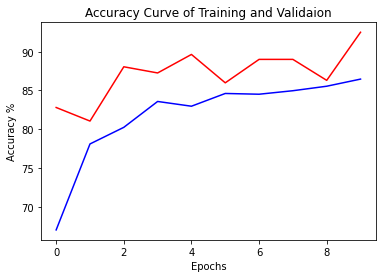

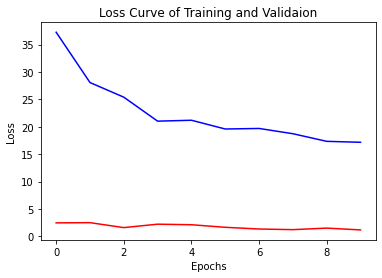

(3, 3)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


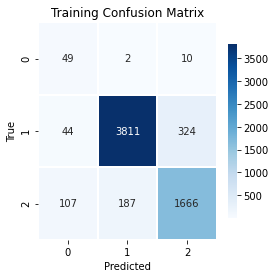

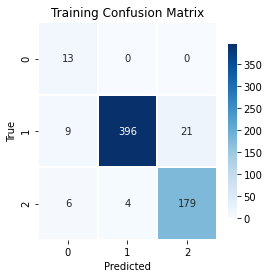

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  vgg16.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # 
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    label=labels
    labels= torch.nn.functional.one_hot(labels, len(class_names))
    for i in range(labels[:,0].shape[0]):
      if(labels[:,0][i]==1):
        labels[:,2][i]=1

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = vgg16(inputs)               #----> forward pass
    # _, predict = torch.max(outputs.data, 1)
  
    loss = criterion(outputs, labels.float())   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    
    limit = Variable(torch.Tensor([0.50])).to(device)
    # # print("Before",outputs)
    # # outputs=torch.Sigmoid(outputs)
    # o=outputs.cpu()
    # o=o.detach().numpy()
    # outputs = 1/(1 + np.exp(-o))
    # # print("Afterr",outputs)
    
    predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    # print("labeleddd", labels)
    # print("outputedd",outputs)
    # print("predicted", predicted)
    
    # total_correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    total_correct += get_num_correct(predicted, labels)
    
    predicted= predicted.cpu().numpy()
    outputs= outputs.cpu().detach().numpy()
    # print("After",predicted)

    for i in range(outputs.shape[0]):
      
      
      
      if (predicted[i]==[1,0,1]).all():
        train_p.extend([0])
        counter+=1
      elif (predicted[i]==[0,1,0]).all():
        train_p.extend([1])
      elif (predicted[i]==[0,0,1]).all():
         train_p.extend([2])
      else:
          l=outputs[i].argmax(axis=0)
          # print("Predicted",predicted[i])
          # print("label:",l)
          train_p.extend([l])

        



    # train_p.extend(predicted)
    train_l.extend(label.cpu().numpy())

    # print("train predicted",train_p)
    
    # print("train label",train_l)

    pbar.set_description(
        
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss,"counter:",counter)
  torch.save(vgg16,"vgg16_focal_loss_exp7.pth")

  vgg16.eval()
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import multilabel_confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  counter=0
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          label=labels
          labels= torch.nn.functional.one_hot(labels, len(class_names))
          for i in range(labels[:,0].shape[0]):
            if(labels[:,0][i]==1):
              labels[:,2][i]=1


          outputs = vgg16(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)

          limit = Variable(torch.Tensor([0.50])).to(device)
          predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    

          loss = criterion(outputs, labels.float())

          correct += get_num_correct(predicted, labels)
          # print("Predicted",predicted)
          # print("Labels",labels)
          
          running_loss += loss.item()
          predicted= predicted.cpu().numpy()
          outputs=outputs.cpu().detach().numpy()

          for i in range(outputs.shape[0]):
            
            
            
            if (predicted[i]==[1,0,1]).all():
              valid_p.extend([0])
              counter+=1
            elif (predicted[i]==[0,1,0]).all():
              valid_p.extend([1])
            elif (predicted[i]==[0,0,1]).all():
              valid_p.extend([2])              # labels[:,2][i]=1
            else:
              l=outputs[i].argmax(axis=0)
              # print("Predicted",predicted[i])
              # print("label:",l)
              valid_p.extend([l])
              
              
            
          # valid_p.extend(predicted)
          valid_l.extend(label.cpu().numpy())
          # print(".",correct)
  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss,"counter:",counter)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)
print(train_input.shape)
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

# **Training Loop (Alpha=2.5, Gamma=0.25, LR=0.001)**

In [0]:
def get_num_correct(preds, labs):
    # return preds.argmax(dim=1).eq(labels).sum().item()
    return torch.sum(torch.all(torch.eq(preds, labs),dim=1)).item()
# vg.train(mode=True)

Epochs = 10
# criterion = nn.BCEWithLogitsLoss()
criterion=FocalLoss(alpha=2.5,gamma=0.25)
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

Train Epoch: 0 [3080/6200 (57%)]	Loss: 0.292946: : 97it [17:02, 10.54s/it]


Train: epoch:  0 total_correct:  3915.0 total_loss:  62.536882013082504 counter: 0
Valid: epoch:  0 total_correct:  550 total_loss:  3.558644488453865 counter: 0
 


Train Epoch: 1 [3080/6200 (57%)]	Loss: 0.423787: : 97it [02:33,  1.58s/it]


Train: epoch:  1 total_correct:  5079.0 total_loss:  37.14195689558983 counter: 0
Valid: epoch:  1 total_correct:  534 total_loss:  3.0458942651748657 counter: 0
 


Train Epoch: 2 [3080/6200 (57%)]	Loss: 0.292906: : 97it [02:32,  1.58s/it]


Train: epoch:  2 total_correct:  5129.0 total_loss:  34.98973661661148 counter: 7
Valid: epoch:  2 total_correct:  561 total_loss:  2.742823377251625 counter: 2
 


Train Epoch: 3 [3080/6200 (57%)]	Loss: 0.345798: : 97it [02:31,  1.56s/it]


Train: epoch:  3 total_correct:  5241.0 total_loss:  32.13204285502434 counter: 18
Valid: epoch:  3 total_correct:  553 total_loss:  2.6134966909885406 counter: 3
 


Train Epoch: 4 [3080/6200 (57%)]	Loss: 0.109717: : 97it [02:32,  1.57s/it]


Train: epoch:  4 total_correct:  5303.0 total_loss:  29.58159251511097 counter: 25
Valid: epoch:  4 total_correct:  561 total_loss:  2.4309422373771667 counter: 2
 


Train Epoch: 5 [3080/6200 (57%)]	Loss: 0.210594: : 97it [02:33,  1.58s/it]


Train: epoch:  5 total_correct:  5290.0 total_loss:  29.68179962038994 counter: 48
Valid: epoch:  5 total_correct:  565 total_loss:  2.3866938799619675 counter: 5
 


Train Epoch: 6 [3080/6200 (57%)]	Loss: 0.168996: : 97it [02:32,  1.58s/it]


Train: epoch:  6 total_correct:  5343.0 total_loss:  27.398038789629936 counter: 64
Valid: epoch:  6 total_correct:  574 total_loss:  2.0807787403464317 counter: 4
 


Train Epoch: 7 [3080/6200 (57%)]	Loss: 0.299192: : 97it [02:32,  1.57s/it]


Train: epoch:  7 total_correct:  5332.0 total_loss:  28.22148160636425 counter: 56
Valid: epoch:  7 total_correct:  567 total_loss:  2.033284544944763 counter: 7
 


Train Epoch: 8 [3080/6200 (57%)]	Loss: 0.298791: : 97it [02:33,  1.58s/it]


Train: epoch:  8 total_correct:  5408.0 total_loss:  26.191629149019718 counter: 71
Valid: epoch:  8 total_correct:  569 total_loss:  1.9671157971024513 counter: 9
 


Train Epoch: 9 [3080/6200 (57%)]	Loss: 0.300691: : 97it [02:30,  1.55s/it]


Train: epoch:  9 total_correct:  5377.0 total_loss:  27.19186805188656 counter: 75
Valid: epoch:  9 total_correct:  564 total_loss:  2.073146440088749 counter: 14
 
Training Accuracy 86.7258064516129 %
Validation Accuracy 89.80891719745223 %
Finished Training


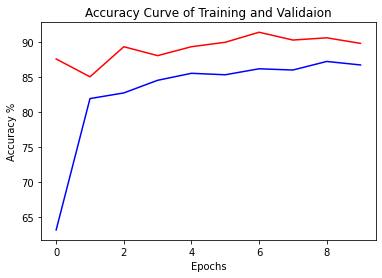

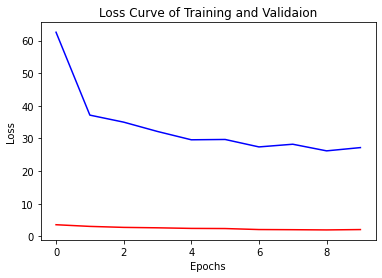

(3, 3)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


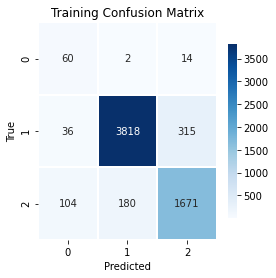

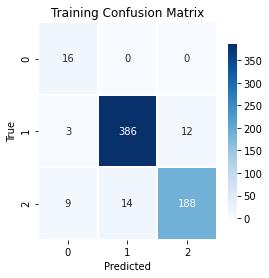

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  vgg16.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # 
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    label=labels
    labels= torch.nn.functional.one_hot(labels, len(class_names))
    for i in range(labels[:,0].shape[0]):
      if(labels[:,0][i]==1):
        labels[:,2][i]=1

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = vgg16(inputs)               #----> forward pass
    # _, predict = torch.max(outputs.data, 1)
  
    loss = criterion(outputs, labels.float())   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    
    limit = Variable(torch.Tensor([0.50])).to(device)
    # # print("Before",outputs)
    # # outputs=torch.Sigmoid(outputs)
    # o=outputs.cpu()
    # o=o.detach().numpy()
    # outputs = 1/(1 + np.exp(-o))
    # # print("Afterr",outputs)
    
    predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    # print("labeleddd", labels)
    # print("outputedd",outputs)
    # print("predicted", predicted)
    
    # total_correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    total_correct += get_num_correct(predicted, labels)
    
    predicted= predicted.cpu().numpy()
    outputs= outputs.cpu().detach().numpy()
    # print("After",predicted)

    for i in range(outputs.shape[0]):
      
      
      
      if (predicted[i]==[1,0,1]).all():
        train_p.extend([0])
        counter+=1
      elif (predicted[i]==[0,1,0]).all():
        train_p.extend([1])
      elif (predicted[i]==[0,0,1]).all():
         train_p.extend([2])
      else:
          l=outputs[i].argmax(axis=0)
          # print("Predicted",predicted[i])
          # print("label:",l)
          train_p.extend([l])

        



    # train_p.extend(predicted)
    train_l.extend(label.cpu().numpy())

    # print("train predicted",train_p)
    
    # print("train label",train_l)

    pbar.set_description(
        
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss,"counter:",counter)
  torch.save(vgg16,"vgg16_focal_loss_exp8.pth")

  vgg16.eval()
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import multilabel_confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  counter=0
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          label=labels
          labels= torch.nn.functional.one_hot(labels, len(class_names))
          for i in range(labels[:,0].shape[0]):
            if(labels[:,0][i]==1):
              labels[:,2][i]=1


          outputs = vgg16(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)

          limit = Variable(torch.Tensor([0.50])).to(device)
          predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    

          loss = criterion(outputs, labels.float())

          correct += get_num_correct(predicted, labels)
          # print("Predicted",predicted)
          # print("Labels",labels)
          
          running_loss += loss.item()
          predicted= predicted.cpu().numpy()
          outputs=outputs.cpu().detach().numpy()

          for i in range(outputs.shape[0]):
            
            
            
            if (predicted[i]==[1,0,1]).all():
              valid_p.extend([0])
              counter+=1
            elif (predicted[i]==[0,1,0]).all():
              valid_p.extend([1])
            elif (predicted[i]==[0,0,1]).all():
              valid_p.extend([2])              # labels[:,2][i]=1
            else:
              l=outputs[i].argmax(axis=0)
              # print("Predicted",predicted[i])
              # print("label:",l)
              valid_p.extend([l])
              
              
            
          # valid_p.extend(predicted)
          valid_l.extend(label.cpu().numpy())
          # print(".",correct)
  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss,"counter:",counter)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)
print(train_input.shape)
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

# **Training Loop (Alpha=2, Gamma=0.5, LR=0.001)**

In [0]:
def get_num_correct(preds, labs):
    # return preds.argmax(dim=1).eq(labels).sum().item()
    return torch.sum(torch.all(torch.eq(preds, labs),dim=1)).item()
# vg.train(mode=True)

Epochs = 10
# criterion = nn.BCEWithLogitsLoss()
criterion=FocalLoss(alpha=2,gamma=0.5)
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

Train Epoch: 0 [3080/6200 (57%)]	Loss: 0.360645: : 97it [02:33,  1.58s/it]


Train: epoch:  0 total_correct:  3864.0 total_loss:  39.731497161090374 counter: 0
Valid: epoch:  0 total_correct:  538 total_loss:  2.2182891219854355 counter: 0
 


Train Epoch: 1 [3080/6200 (57%)]	Loss: 0.191310: : 97it [02:32,  1.57s/it]


Train: epoch:  1 total_correct:  4984.0 total_loss:  22.68358437716961 counter: 0
Valid: epoch:  1 total_correct:  546 total_loss:  1.5223279669880867 counter: 0
 


Train Epoch: 2 [3080/6200 (57%)]	Loss: 0.118667: : 97it [02:33,  1.58s/it]


Train: epoch:  2 total_correct:  5099.0 total_loss:  19.819152131676674 counter: 0
Valid: epoch:  2 total_correct:  536 total_loss:  1.5044811256229877 counter: 0
 


Train Epoch: 3 [3080/6200 (57%)]	Loss: 0.154308: : 97it [02:33,  1.58s/it]


Train: epoch:  3 total_correct:  5209.0 total_loss:  16.83379153162241 counter: 2
Valid: epoch:  3 total_correct:  540 total_loss:  1.9959700852632523 counter: 0
 


Train Epoch: 4 [3080/6200 (57%)]	Loss: 0.102630: : 97it [02:33,  1.58s/it]


Train: epoch:  4 total_correct:  5262.0 total_loss:  15.526241589337587 counter: 12
Valid: epoch:  4 total_correct:  549 total_loss:  1.2167622819542885 counter: 4
 


Train Epoch: 5 [3080/6200 (57%)]	Loss: 0.179554: : 97it [02:32,  1.57s/it]


Train: epoch:  5 total_correct:  5256.0 total_loss:  16.26589709147811 counter: 30
Valid: epoch:  5 total_correct:  542 total_loss:  1.3332921117544174 counter: 1
 


Train Epoch: 6 [3080/6200 (57%)]	Loss: 0.078812: : 97it [02:31,  1.56s/it]


Train: epoch:  6 total_correct:  5309.0 total_loss:  14.749891329556704 counter: 35
Valid: epoch:  6 total_correct:  563 total_loss:  1.1212564930319786 counter: 2
 


Train Epoch: 7 [3080/6200 (57%)]	Loss: 0.099363: : 97it [02:31,  1.56s/it]


Train: epoch:  7 total_correct:  5271.0 total_loss:  15.943238504230976 counter: 47
Valid: epoch:  7 total_correct:  570 total_loss:  1.0746053978800774 counter: 5
 


Train Epoch: 8 [3080/6200 (57%)]	Loss: 0.219584: : 97it [02:31,  1.56s/it]


Train: epoch:  8 total_correct:  5317.0 total_loss:  15.011024493724108 counter: 38
Valid: epoch:  8 total_correct:  567 total_loss:  1.1129373162984848 counter: 2
 


Train Epoch: 9 [3080/6200 (57%)]	Loss: 0.043831: : 97it [02:31,  1.56s/it]


Train: epoch:  9 total_correct:  5358.0 total_loss:  13.589638754725456 counter: 60
Valid: epoch:  9 total_correct:  569 total_loss:  1.0028795935213566 counter: 7
 
Training Accuracy 86.41935483870968 %
Validation Accuracy 90.60509554140127 %
Finished Training


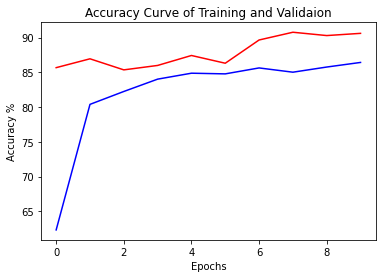

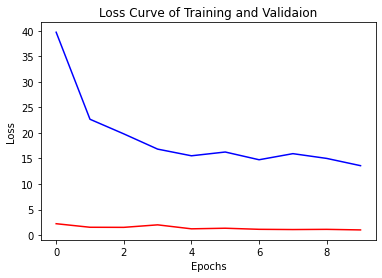

(3, 3)


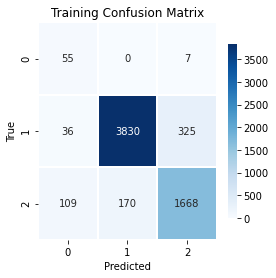

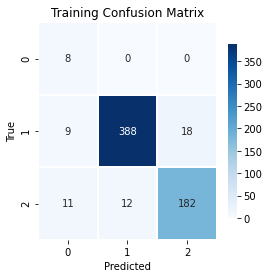

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  vgg16.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # 
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    label=labels
    labels= torch.nn.functional.one_hot(labels, len(class_names))
    for i in range(labels[:,0].shape[0]):
      if(labels[:,0][i]==1):
        labels[:,2][i]=1

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = vgg16(inputs)               #----> forward pass
    # _, predict = torch.max(outputs.data, 1)
  
    loss = criterion(outputs, labels.float())   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    
    limit = Variable(torch.Tensor([0.50])).to(device)
    # # print("Before",outputs)
    # # outputs=torch.Sigmoid(outputs)
    # o=outputs.cpu()
    # o=o.detach().numpy()
    # outputs = 1/(1 + np.exp(-o))
    # # print("Afterr",outputs)
    
    predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    # print("labeleddd", labels)
    # print("outputedd",outputs)
    # print("predicted", predicted)
    
    # total_correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    total_correct += get_num_correct(predicted, labels)
    
    predicted= predicted.cpu().numpy()
    outputs= outputs.cpu().detach().numpy()
    # print("After",predicted)

    for i in range(outputs.shape[0]):
      
      
      
      if (predicted[i]==[1,0,1]).all():
        train_p.extend([0])
        counter+=1
      elif (predicted[i]==[0,1,0]).all():
        train_p.extend([1])
      elif (predicted[i]==[0,0,1]).all():
         train_p.extend([2])
      else:
          l=outputs[i].argmax(axis=0)
          # print("Predicted",predicted[i])
          # print("label:",l)
          train_p.extend([l])

        



    # train_p.extend(predicted)
    train_l.extend(label.cpu().numpy())

    # print("train predicted",train_p)
    
    # print("train label",train_l)

    pbar.set_description(
        
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss,"counter:",counter)
  torch.save(vgg16,"vgg16_focal_loss_exp9.pth")

  vgg16.eval()
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import multilabel_confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  counter=0
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          label=labels
          labels= torch.nn.functional.one_hot(labels, len(class_names))
          for i in range(labels[:,0].shape[0]):
            if(labels[:,0][i]==1):
              labels[:,2][i]=1


          outputs = vgg16(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)

          limit = Variable(torch.Tensor([0.50])).to(device)
          predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    

          loss = criterion(outputs, labels.float())

          correct += get_num_correct(predicted, labels)
          # print("Predicted",predicted)
          # print("Labels",labels)
          
          running_loss += loss.item()
          predicted= predicted.cpu().numpy()
          outputs=outputs.cpu().detach().numpy()

          for i in range(outputs.shape[0]):
            
            
            
            if (predicted[i]==[1,0,1]).all():
              valid_p.extend([0])
              counter+=1
            elif (predicted[i]==[0,1,0]).all():
              valid_p.extend([1])
            elif (predicted[i]==[0,0,1]).all():
              valid_p.extend([2])              # labels[:,2][i]=1
            else:
              l=outputs[i].argmax(axis=0)
              # print("Predicted",predicted[i])
              # print("label:",l)
              valid_p.extend([l])
              
              
            
          # valid_p.extend(predicted)
          valid_l.extend(label.cpu().numpy())
          # print(".",correct)
  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss,"counter:",counter)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)
print(train_input.shape)
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

# **Train Resnet18** Focal Loss

In [0]:
resnet18=models.resnet18(pretrained=True, progress=True)
print("hi")

features=[]
features.extend([nn.Linear(in_features=512,out_features=630+100,bias=True)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5,inplace=False)])
features.extend([nn.Linear(in_features=630+100,out_features=3,bias=False)])
resnet18.fc=nn.Sequential(*features)
resnet18

hi


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# **Training Loop (Alpha=0.5, Gamma=2, LR=0.001)**

In [0]:
def get_num_correct(preds, labs):
    # return preds.argmax(dim=1).eq(labels).sum().item()
    return torch.sum(torch.all(torch.eq(preds, labs),dim=1)).item()


Epochs = 10
criterion = FocalLoss(alpha=0.5,gamma=2)
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)


Train Epoch: 0 [3080/6200 (57%)]	Loss: 0.024309: : 97it [17:50, 11.04s/it]


Train: epoch:  0 total_correct:  1503.0 total_loss:  4.2902679573744535 counter: 0
Valid: epoch:  0 total_correct:  397 total_loss:  0.3386307377368212 counter: 0
 


Train Epoch: 1 [3080/6200 (57%)]	Loss: 0.032026: : 97it [02:05,  1.30s/it]


Train: epoch:  1 total_correct:  2819.0 total_loss:  3.0970702823251486 counter: 0
Valid: epoch:  1 total_correct:  395 total_loss:  0.2910868972539902 counter: 0
 


Train Epoch: 2 [3080/6200 (57%)]	Loss: 0.023463: : 97it [02:03,  1.27s/it]


Train: epoch:  2 total_correct:  2958.0 total_loss:  2.7762599736452103 counter: 0
Valid: epoch:  2 total_correct:  392 total_loss:  0.2609676839783788 counter: 0
 


Train Epoch: 3 [3080/6200 (57%)]	Loss: 0.023459: : 97it [02:03,  1.27s/it]


Train: epoch:  3 total_correct:  3108.0 total_loss:  2.488527630455792 counter: 0
Valid: epoch:  3 total_correct:  377 total_loss:  0.2241507787257433 counter: 0
 


Train Epoch: 4 [3080/6200 (57%)]	Loss: 0.014149: : 97it [02:03,  1.28s/it]


Train: epoch:  4 total_correct:  3176.0 total_loss:  2.2361430609598756 counter: 0
Valid: epoch:  4 total_correct:  371 total_loss:  0.20002723578363657 counter: 0
 


Train Epoch: 5 [3080/6200 (57%)]	Loss: 0.014647: : 97it [02:03,  1.27s/it]


Train: epoch:  5 total_correct:  3275.0 total_loss:  2.001162921078503 counter: 0
Valid: epoch:  5 total_correct:  375 total_loss:  0.1812265426851809 counter: 0
 


Train Epoch: 6 [3080/6200 (57%)]	Loss: 0.016080: : 97it [02:04,  1.28s/it]


Train: epoch:  6 total_correct:  3430.0 total_loss:  1.8322158129885793 counter: 0
Valid: epoch:  6 total_correct:  404 total_loss:  0.15143024176359177 counter: 0
 


Train Epoch: 7 [3080/6200 (57%)]	Loss: 0.014576: : 97it [02:03,  1.28s/it]


Train: epoch:  7 total_correct:  3623.0 total_loss:  1.6765431645326316 counter: 0
Valid: epoch:  7 total_correct:  434 total_loss:  0.14260956225916743 counter: 0
 


Train Epoch: 8 [3080/6200 (57%)]	Loss: 0.011927: : 97it [02:04,  1.28s/it]


Train: epoch:  8 total_correct:  3837.0 total_loss:  1.4995459811761975 counter: 0
Valid: epoch:  8 total_correct:  459 total_loss:  0.13312711752951145 counter: 0
 


Train Epoch: 9 [3080/6200 (57%)]	Loss: 0.010183: : 97it [02:05,  1.29s/it]


Train: epoch:  9 total_correct:  4000.0 total_loss:  1.4076703088358045 counter: 0
Valid: epoch:  9 total_correct:  480 total_loss:  0.11380889639258385 counter: 0
 
Training Accuracy 64.51612903225806 %
Validation Accuracy 76.43312101910828 %
Finished Training


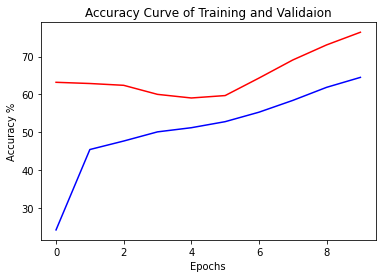

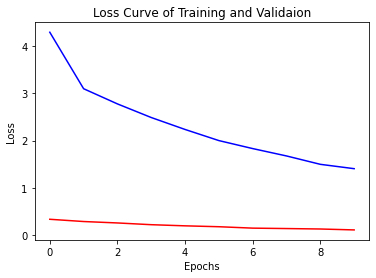

(3, 3)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


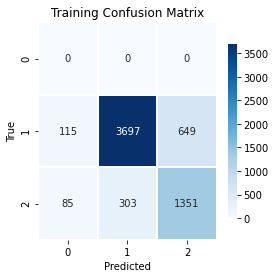

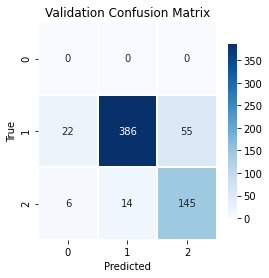

ValueError: ignored

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  resnet18.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # 
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    label=labels
    labels= torch.nn.functional.one_hot(labels, len(class_names))
    for i in range(labels[:,0].shape[0]):
      if(labels[:,0][i]==1):
        labels[:,2][i]=1

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = resnet18(inputs)               #----> forward pass
    # _, predict = torch.max(outputs.data, 1)
  
    loss = criterion(outputs, labels.float())   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    
    limit = Variable(torch.Tensor([0.50])).to(device)
    # # print("Before",outputs)
    # # outputs=torch.Sigmoid(outputs)
    # o=outputs.cpu()
    # o=o.detach().numpy()
    # outputs = 1/(1 + np.exp(-o))
    # # print("Afterr",outputs)
    
    predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    # print("labeleddd", labels)
    # print("outputedd",outputs)
    # print("predicted", predicted)
    
    # total_correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    total_correct += get_num_correct(predicted, labels)
    
    predicted= predicted.cpu().numpy()
    outputs= outputs.cpu().detach().numpy()
    # print("After",predicted)

    for i in range(outputs.shape[0]):
      
      
      
      if (predicted[i]==[1,0,1]).all():
        train_p.extend([0])
        counter+=1
      elif (predicted[i]==[0,1,0]).all():
        train_p.extend([1])
      elif (predicted[i]==[0,0,1]).all():
         train_p.extend([2])
      else:
          l=outputs[i].argmax(axis=0)
          # print("Predicted",predicted[i])
          # print("label:",l)
          train_p.extend([l])

        



    # train_p.extend(predicted)
    train_l.extend(label.cpu().numpy())

    # print("train predicted",train_p)
    
    # print("train label",train_l)

    pbar.set_description(
        
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss,"counter:",counter)
  torch.save(resnet18,"‘res18_focal_loss.pth")

  resnet18.eval()
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import multilabel_confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  counter=0
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          label=labels
          labels= torch.nn.functional.one_hot(labels, len(class_names))
          for i in range(labels[:,0].shape[0]):
            if(labels[:,0][i]==1):
              labels[:,2][i]=1


          outputs = resnet18(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)

          limit = Variable(torch.Tensor([0.50])).to(device)
          predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    

          loss = criterion(outputs, labels.float())

          correct += get_num_correct(predicted, labels)
          # print("Predicted",predicted)
          # print("Labels",labels)
          
          running_loss += loss.item()
          predicted= predicted.cpu().numpy()
          outputs=outputs.cpu().detach().numpy()

          for i in range(outputs.shape[0]):
            
            
            
            if (predicted[i]==[1,0,1]).all():
              valid_p.extend([0])
              counter+=1
            elif (predicted[i]==[0,1,0]).all():
              valid_p.extend([1])
            elif (predicted[i]==[0,0,1]).all():
              valid_p.extend([2])              # labels[:,2][i]=1
            else:
              l=outputs[i].argmax(axis=0)
              # print("Predicted",predicted[i])
              # print("label:",l)
              valid_p.extend([l])
              
              
            
          # valid_p.extend(predicted)
          valid_l.extend(label.cpu().numpy())
          # print(".",correct)
  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss,"counter:",counter)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)
print(train_input.shape)
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Validation Confusion Matrix")
plt.show()

from sklearn.metrics import f1_score
print("Training   F1 Score :",f1_score(train_l, train_p)) # p are predicted labels and l are true labels
print("Validation F1 Score :",f1_score(valid_l, valid_p)) # p are predicted labels and l are true labels


# **Training Loop (Alpha=2, Gamma=1, LR=0.001)**

In [0]:
def get_num_correct(preds, labs):
    # return preds.argmax(dim=1).eq(labels).sum().item()
    return torch.sum(torch.all(torch.eq(preds, labs),dim=1)).item()


Epochs = 10
criterion = FocalLoss(alpha=2,gamma=1)
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)


Train Epoch: 0 [3080/6200 (57%)]	Loss: 0.210902: : 97it [02:07,  1.31s/it]


Train: epoch:  0 total_correct:  2986.0 total_loss:  31.231685921549797 counter: 1
Valid: epoch:  0 total_correct:  421 total_loss:  2.1219000071287155 counter: 0
 


Train Epoch: 1 [3080/6200 (57%)]	Loss: 0.131370: : 97it [02:05,  1.29s/it]


Train: epoch:  1 total_correct:  4320.0 total_loss:  16.995476827025414 counter: 0
Valid: epoch:  1 total_correct:  503 total_loss:  1.1908839419484138 counter: 0
 


Train Epoch: 2 [3080/6200 (57%)]	Loss: 0.065838: : 97it [02:05,  1.29s/it]


Train: epoch:  2 total_correct:  4837.0 total_loss:  12.514333311468363 counter: 0
Valid: epoch:  2 total_correct:  527 total_loss:  0.921640258282423 counter: 0
 


Train Epoch: 3 [3080/6200 (57%)]	Loss: 0.093308: : 97it [02:04,  1.28s/it]


Train: epoch:  3 total_correct:  4996.0 total_loss:  10.644996788352728 counter: 0
Valid: epoch:  3 total_correct:  528 total_loss:  0.818003298714757 counter: 0
 


Train Epoch: 4 [3080/6200 (57%)]	Loss: 0.061270: : 97it [02:04,  1.29s/it]


Train: epoch:  4 total_correct:  5003.0 total_loss:  9.796297132968903 counter: 0
Valid: epoch:  4 total_correct:  539 total_loss:  0.7190113514661789 counter: 0
 


Train Epoch: 5 [3080/6200 (57%)]	Loss: 0.053459: : 97it [02:04,  1.28s/it]


Train: epoch:  5 total_correct:  5132.0 total_loss:  8.615580037236214 counter: 0
Valid: epoch:  5 total_correct:  551 total_loss:  0.6596034597605467 counter: 0
 


Train Epoch: 6 [3080/6200 (57%)]	Loss: 0.108598: : 97it [02:04,  1.28s/it]


Train: epoch:  6 total_correct:  5159.0 total_loss:  8.051382191479206 counter: 0
Valid: epoch:  6 total_correct:  539 total_loss:  0.6696822308003902 counter: 0
 


Train Epoch: 7 [3080/6200 (57%)]	Loss: 0.157728: : 97it [02:03,  1.28s/it]


Train: epoch:  7 total_correct:  5177.0 total_loss:  7.944325938820839 counter: 0
Valid: epoch:  7 total_correct:  550 total_loss:  0.5980156790465117 counter: 0
 


Train Epoch: 8 [3080/6200 (57%)]	Loss: 0.127711: : 97it [02:04,  1.28s/it]


Train: epoch:  8 total_correct:  5211.0 total_loss:  7.495817935094237 counter: 0
Valid: epoch:  8 total_correct:  529 total_loss:  0.6531679332256317 counter: 0
 


Train Epoch: 9 [3080/6200 (57%)]	Loss: 0.031530: : 97it [02:03,  1.28s/it]


Train: epoch:  9 total_correct:  5210.0 total_loss:  7.043546492233872 counter: 0
Valid: epoch:  9 total_correct:  555 total_loss:  0.5059519112110138 counter: 0
 
Training Accuracy 84.03225806451613 %
Validation Accuracy 88.37579617834395 %
Finished Training


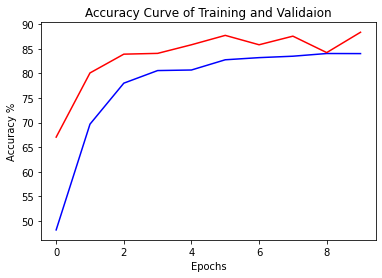

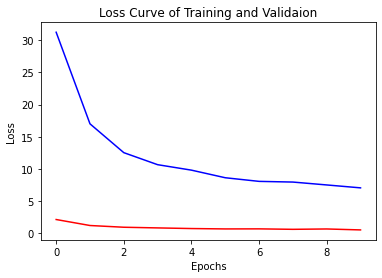

(3, 3)


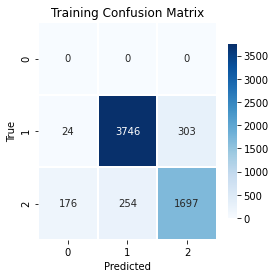

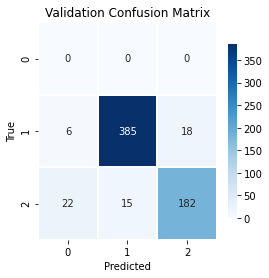

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  resnet18.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # 
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    label=labels
    labels= torch.nn.functional.one_hot(labels, len(class_names))
    for i in range(labels[:,0].shape[0]):
      if(labels[:,0][i]==1):
        labels[:,2][i]=1

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = resnet18(inputs)               #----> forward pass
    # _, predict = torch.max(outputs.data, 1)
  
    loss = criterion(outputs, labels.float())   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    
    limit = Variable(torch.Tensor([0.50])).to(device)
    # # print("Before",outputs)
    # # outputs=torch.Sigmoid(outputs)
    # o=outputs.cpu()
    # o=o.detach().numpy()
    # outputs = 1/(1 + np.exp(-o))
    # # print("Afterr",outputs)
    
    predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    # print("labeleddd", labels)
    # print("outputedd",outputs)
    # print("predicted", predicted)
    
    # total_correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    total_correct += get_num_correct(predicted, labels)
    
    predicted= predicted.cpu().numpy()
    outputs= outputs.cpu().detach().numpy()
    # print("After",predicted)

    for i in range(outputs.shape[0]):
      
      
      
      if (predicted[i]==[1,0,1]).all():
        train_p.extend([0])
        counter+=1
      elif (predicted[i]==[0,1,0]).all():
        train_p.extend([1])
      elif (predicted[i]==[0,0,1]).all():
         train_p.extend([2])
      else:
          l=outputs[i].argmax(axis=0)
          # print("Predicted",predicted[i])
          # print("label:",l)
          train_p.extend([l])

        



    # train_p.extend(predicted)
    train_l.extend(label.cpu().numpy())

    # print("train predicted",train_p)
    
    # print("train label",train_l)

    pbar.set_description(
        
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss,"counter:",counter)
  torch.save(resnet18,"‘res18_focal_loss_exp2.pth")

  resnet18.eval()
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import multilabel_confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  counter=0
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          label=labels
          labels= torch.nn.functional.one_hot(labels, len(class_names))
          for i in range(labels[:,0].shape[0]):
            if(labels[:,0][i]==1):
              labels[:,2][i]=1


          outputs = resnet18(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)

          limit = Variable(torch.Tensor([0.50])).to(device)
          predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    

          loss = criterion(outputs, labels.float())

          correct += get_num_correct(predicted, labels)
          # print("Predicted",predicted)
          # print("Labels",labels)
          
          running_loss += loss.item()
          predicted= predicted.cpu().numpy()
          outputs=outputs.cpu().detach().numpy()

          for i in range(outputs.shape[0]):
            
            
            
            if (predicted[i]==[1,0,1]).all():
              valid_p.extend([0])
              counter+=1
            elif (predicted[i]==[0,1,0]).all():
              valid_p.extend([1])
            elif (predicted[i]==[0,0,1]).all():
              valid_p.extend([2])              # labels[:,2][i]=1
            else:
              l=outputs[i].argmax(axis=0)
              # print("Predicted",predicted[i])
              # print("label:",l)
              valid_p.extend([l])
              
              
            
          # valid_p.extend(predicted)
          valid_l.extend(label.cpu().numpy())
          # print(".",correct)
  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss,"counter:",counter)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)
print(train_input.shape)
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Validation Confusion Matrix")
plt.show()

# from sklearn.metrics import f1_score
# print("Training   F1 Score :",f1_score(train_l, train_p)) # p are predicted labels and l are true labels
# print("Validation F1 Score :",f1_score(valid_l, valid_p)) # p are predicted labels and l are true labels


# **Training Loop (Alpha=2, Gamma=1, LR=0.01) BEST MODEL 0_0**

In [0]:
def get_num_correct(preds, labs):
    # return preds.argmax(dim=1).eq(labels).sum().item()
    return torch.sum(torch.all(torch.eq(preds, labs),dim=1)).item()


Epochs = 10
criterion = FocalLoss(alpha=2,gamma=1)
optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9)


Train Epoch: 0 [3080/6200 (57%)]	Loss: 0.136914: : 97it [02:04,  1.29s/it]


Train: epoch:  0 total_correct:  4442.0 total_loss:  17.056032668799162 counter: 0
Valid: epoch:  0 total_correct:  530 total_loss:  0.8759005144238472 counter: 0
 


Train Epoch: 1 [3080/6200 (57%)]	Loss: 0.120526: : 97it [02:04,  1.28s/it]


Train: epoch:  1 total_correct:  5029.0 total_loss:  9.917666355147958 counter: 0
Valid: epoch:  1 total_correct:  542 total_loss:  0.7715783007442951 counter: 0
 


Train Epoch: 2 [3080/6200 (57%)]	Loss: 0.114952: : 97it [02:04,  1.28s/it]


Train: epoch:  2 total_correct:  5183.0 total_loss:  7.891548132523894 counter: 0
Valid: epoch:  2 total_correct:  555 total_loss:  0.528918860014528 counter: 0
 


Train Epoch: 3 [3080/6200 (57%)]	Loss: 0.055385: : 97it [02:04,  1.28s/it]


Train: epoch:  3 total_correct:  5254.0 total_loss:  6.57911308016628 counter: 23
Valid: epoch:  3 total_correct:  569 total_loss:  0.3842242993414402 counter: 6
 


Train Epoch: 4 [3080/6200 (57%)]	Loss: 0.080844: : 97it [02:03,  1.28s/it]


Train: epoch:  4 total_correct:  5304.0 total_loss:  6.629295768216252 counter: 42
Valid: epoch:  4 total_correct:  557 total_loss:  0.5060156537219882 counter: 4
 


Train Epoch: 5 [3080/6200 (57%)]	Loss: 0.074659: : 97it [02:03,  1.27s/it]


Train: epoch:  5 total_correct:  5364.0 total_loss:  5.9270157823339105 counter: 60
Valid: epoch:  5 total_correct:  570 total_loss:  0.2935742372646928 counter: 10
 


Train Epoch: 6 [3080/6200 (57%)]	Loss: 0.061160: : 97it [02:03,  1.27s/it]


Train: epoch:  6 total_correct:  5342.0 total_loss:  5.715413477271795 counter: 79
Valid: epoch:  6 total_correct:  563 total_loss:  0.4636248480528593 counter: 5
 


Train Epoch: 7 [3080/6200 (57%)]	Loss: 0.055774: : 97it [02:03,  1.28s/it]


Train: epoch:  7 total_correct:  5354.0 total_loss:  5.530183211900294 counter: 78
Valid: epoch:  7 total_correct:  574 total_loss:  0.39432620629668236 counter: 12
 


Train Epoch: 8 [3080/6200 (57%)]	Loss: 0.047694: : 97it [02:03,  1.27s/it]


Train: epoch:  8 total_correct:  5453.0 total_loss:  4.887810499407351 counter: 91
Valid: epoch:  8 total_correct:  558 total_loss:  0.6107260473072529 counter: 8
 


Train Epoch: 9 [3080/6200 (57%)]	Loss: 0.018729: : 97it [02:03,  1.28s/it]


Train: epoch:  9 total_correct:  5422.0 total_loss:  4.972562350332737 counter: 95
Valid: epoch:  9 total_correct:  579 total_loss:  0.2793293772265315 counter: 17
 
Training Accuracy 87.45161290322581 %
Validation Accuracy 92.19745222929936 %
Finished Training


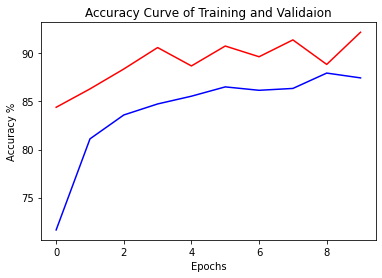

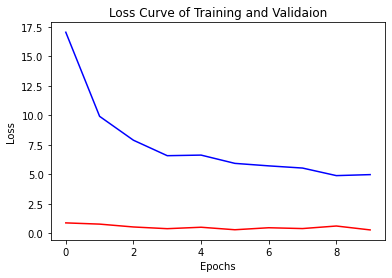

(3, 3)


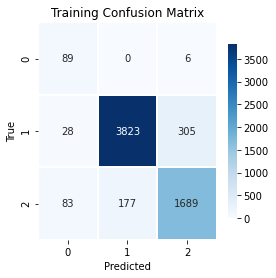

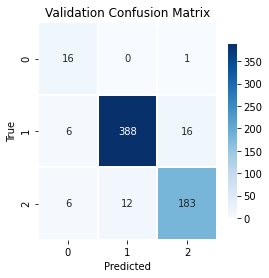

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  resnet18.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # 
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    label=labels
    labels= torch.nn.functional.one_hot(labels, len(class_names))
    for i in range(labels[:,0].shape[0]):
      if(labels[:,0][i]==1):
        labels[:,2][i]=1

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = resnet18(inputs)               #----> forward pass
    # _, predict = torch.max(outputs.data, 1)
  
    loss = criterion(outputs, labels.float())   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    
    limit = Variable(torch.Tensor([0.50])).to(device)
    # # print("Before",outputs)
    # # outputs=torch.Sigmoid(outputs)
    # o=outputs.cpu()
    # o=o.detach().numpy()
    # outputs = 1/(1 + np.exp(-o))
    # # print("Afterr",outputs)
    
    predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    # print("labeleddd", labels)
    # print("outputedd",outputs)
    # print("predicted", predicted)
    
    # total_correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    total_correct += get_num_correct(predicted, labels)
    
    predicted= predicted.cpu().numpy()
    outputs= outputs.cpu().detach().numpy()
    # print("After",predicted)

    for i in range(outputs.shape[0]):
      
      
      
      if (predicted[i]==[1,0,1]).all():
        train_p.extend([0])
        counter+=1
      elif (predicted[i]==[0,1,0]).all():
        train_p.extend([1])
      elif (predicted[i]==[0,0,1]).all():
         train_p.extend([2])
      else:
          l=outputs[i].argmax(axis=0)
          # print("Predicted",predicted[i])
          # print("label:",l)
          train_p.extend([l])

        



    # train_p.extend(predicted)
    train_l.extend(label.cpu().numpy())

    # print("train predicted",train_p)
    
    # print("train label",train_l)

    pbar.set_description(
        
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss,"counter:",counter)
  torch.save(resnet18,"res18_focal_loss_exp3.pth")

  resnet18.eval()
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import multilabel_confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  counter=0
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          label=labels
          labels= torch.nn.functional.one_hot(labels, len(class_names))
          for i in range(labels[:,0].shape[0]):
            if(labels[:,0][i]==1):
              labels[:,2][i]=1


          outputs = resnet18(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)

          limit = Variable(torch.Tensor([0.50])).to(device)
          predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    

          loss = criterion(outputs, labels.float())

          correct += get_num_correct(predicted, labels)
          # print("Predicted",predicted)
          # print("Labels",labels)
          
          running_loss += loss.item()
          predicted= predicted.cpu().numpy()
          outputs=outputs.cpu().detach().numpy()

          for i in range(outputs.shape[0]):
            
            
            
            if (predicted[i]==[1,0,1]).all():
              valid_p.extend([0])
              counter+=1
            elif (predicted[i]==[0,1,0]).all():
              valid_p.extend([1])
            elif (predicted[i]==[0,0,1]).all():
              valid_p.extend([2])              # labels[:,2][i]=1
            else:
              l=outputs[i].argmax(axis=0)
              # print("Predicted",predicted[i])
              # print("label:",l)
              valid_p.extend([l])
              
              
            
          # valid_p.extend(predicted)
          valid_l.extend(label.cpu().numpy())
          # print(".",correct)
  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss,"counter:",counter)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)
print(train_input.shape)
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Validation Confusion Matrix")
plt.show()

# from sklearn.metrics import f1_score
# print("Training   F1 Score :",f1_score(train_l, train_p)) # p are predicted labels and l are true labels
# print("Validation F1 Score :",f1_score(valid_l, valid_p)) # p are predicted labels and l are true labels


Confusion Matrix Repeat . . .

17
 
Validation Accuracy 92.19745222929936 %
Validation F1 Score : 0.9347133757961783


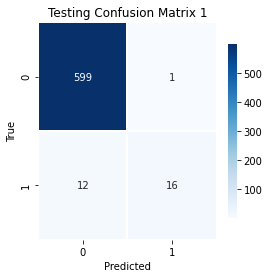

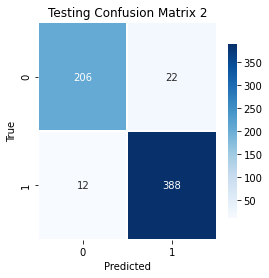

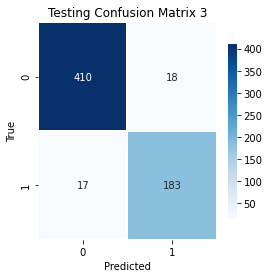

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score


resnet18=torch.load("res18_focal_loss_exp3.pth")
resnet18.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

correct = 0
total = 0

running_loss=0.0

valid_p=[]
valid_l=[]
counter=0
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        label=labels
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        for i in range(labels[:,0].shape[0]):
          if(labels[:,0][i]==1):
            labels[:,2][i]=1


        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        limit = Variable(torch.Tensor([0.50])).to(device)
        predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
  

        loss = criterion(outputs, labels.float())

        correct += get_num_correct(predicted, labels)
        # print("Predicted",predicted)
        # print("Labels",labels)
        
        running_loss += loss.item()
        predicted= predicted.cpu().numpy()
        outputs=outputs.cpu().detach().numpy()

        for i in range(outputs.shape[0]):
          
          
          
          if (predicted[i]==[1,0,1]).all():
            valid_p.extend([0])
            counter+=1
          elif (predicted[i]==[0,1,0]).all():
            valid_p.extend([1])
          elif (predicted[i]==[0,0,1]).all():
            valid_p.extend([2])              # labels[:,2][i]=1
          else:
            l=outputs[i].argmax(axis=0)
            # print("Predicted",predicted[i])
            # print("label:",l)
            valid_p.extend([l])
            
            
          
        # valid_p.extend(predicted)
        valid_l.extend(label.cpu().numpy())
        # print(".",correct)
# valid_acc.append((100 * correct) / total)
# valid_loss.append(running_loss)
print(counter)
print(" ")


print("Validation Accuracy",((100 * correct) / total),"%")
print("Validation F1 Score :",f1_score(valid_l, valid_p, average="micro")) # p are predicted labels and l are true labels

valid_input=multilabel_confusion_matrix(valid_l,valid_p)

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input[0],cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix 1")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input[1],cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix 2")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input[2],cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Testing Confusion Matrix 3")
plt.show()


# f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="micro"))

# **Training Loop (Alpha=1.5, Gamma=1, LR=0.001)**

In [0]:
def get_num_correct(preds, labs):
    # return preds.argmax(dim=1).eq(labels).sum().item()
    return torch.sum(torch.all(torch.eq(preds, labs),dim=1)).item()


Epochs = 10
criterion = FocalLoss(alpha=1.5,gamma=1)
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)


Train Epoch: 0 [3080/6200 (57%)]	Loss: 0.220679: : 97it [02:08,  1.32s/it]


Train: epoch:  0 total_correct:  2854.0 total_loss:  25.068765997886658 counter: 0
Valid: epoch:  0 total_correct:  367 total_loss:  1.9436791688203812 counter: 0
 


Train Epoch: 1 [3080/6200 (57%)]	Loss: 0.177270: : 97it [02:09,  1.34s/it]


Train: epoch:  1 total_correct:  3724.0 total_loss:  15.8320666924119 counter: 0
Valid: epoch:  1 total_correct:  484 total_loss:  1.1646436154842377 counter: 0
 


Train Epoch: 2 [3080/6200 (57%)]	Loss: 0.104418: : 97it [02:08,  1.33s/it]


Train: epoch:  2 total_correct:  4573.0 total_loss:  11.058136213570833 counter: 0
Valid: epoch:  2 total_correct:  511 total_loss:  0.9296402800828218 counter: 0
 


Train Epoch: 3 [3080/6200 (57%)]	Loss: 0.117932: : 97it [02:09,  1.33s/it]


Train: epoch:  3 total_correct:  4799.0 total_loss:  9.533694695681334 counter: 0
Valid: epoch:  3 total_correct:  521 total_loss:  0.7652378007769585 counter: 0
 


Train Epoch: 4 [3080/6200 (57%)]	Loss: 0.029640: : 97it [02:08,  1.32s/it]


Train: epoch:  4 total_correct:  4913.0 total_loss:  8.330212589353323 counter: 0
Valid: epoch:  4 total_correct:  528 total_loss:  0.6877556629478931 counter: 0
 


Train Epoch: 5 [3080/6200 (57%)]	Loss: 0.052643: : 97it [02:09,  1.34s/it]


Train: epoch:  5 total_correct:  4984.0 total_loss:  7.7039806470274925 counter: 0
Valid: epoch:  5 total_correct:  536 total_loss:  0.6433148346841335 counter: 0
 


Train Epoch: 6 [3080/6200 (57%)]	Loss: 0.082994: : 97it [02:10,  1.34s/it]


Train: epoch:  6 total_correct:  5070.0 total_loss:  6.771293047815561 counter: 0
Valid: epoch:  6 total_correct:  525 total_loss:  0.5761945694684982 counter: 0
 


Train Epoch: 7 [3080/6200 (57%)]	Loss: 0.050622: : 97it [02:11,  1.36s/it]


Train: epoch:  7 total_correct:  5142.0 total_loss:  6.369902087375522 counter: 0
Valid: epoch:  7 total_correct:  536 total_loss:  0.5441418066620827 counter: 0
 


Train Epoch: 8 [3080/6200 (57%)]	Loss: 0.023107: : 97it [02:06,  1.31s/it]


Train: epoch:  8 total_correct:  5173.0 total_loss:  5.874975407496095 counter: 0
Valid: epoch:  8 total_correct:  529 total_loss:  0.5578241683542728 counter: 0
 


Train Epoch: 9 [3080/6200 (57%)]	Loss: 0.044764: : 97it [02:05,  1.29s/it]


Train: epoch:  9 total_correct:  5168.0 total_loss:  6.015346076339483 counter: 0
Valid: epoch:  9 total_correct:  545 total_loss:  0.4376301374286413 counter: 0
 
Training Accuracy 83.35483870967742 %
Validation Accuracy 86.78343949044586 %
Finished Training


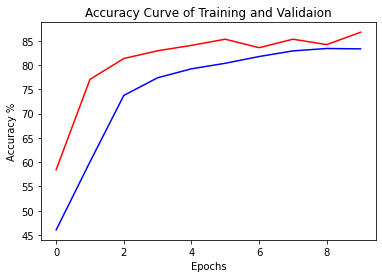

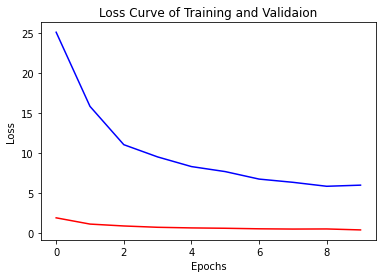

(3, 3)


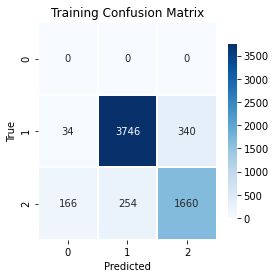

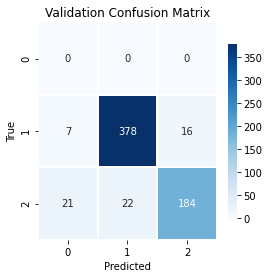

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  resnet18.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # 
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    label=labels
    labels= torch.nn.functional.one_hot(labels, len(class_names))
    for i in range(labels[:,0].shape[0]):
      if(labels[:,0][i]==1):
        labels[:,2][i]=1

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = resnet18(inputs)               #----> forward pass
    # _, predict = torch.max(outputs.data, 1)
  
    loss = criterion(outputs, labels.float())   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    
    limit = Variable(torch.Tensor([0.50])).to(device)
    # # print("Before",outputs)
    # # outputs=torch.Sigmoid(outputs)
    # o=outputs.cpu()
    # o=o.detach().numpy()
    # outputs = 1/(1 + np.exp(-o))
    # # print("Afterr",outputs)
    
    predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    # print("labeleddd", labels)
    # print("outputedd",outputs)
    # print("predicted", predicted)
    
    # total_correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    total_correct += get_num_correct(predicted, labels)
    
    predicted= predicted.cpu().numpy()
    outputs= outputs.cpu().detach().numpy()
    # print("After",predicted)

    for i in range(outputs.shape[0]):
      
      
      
      if (predicted[i]==[1,0,1]).all():
        train_p.extend([0])
        counter+=1
      elif (predicted[i]==[0,1,0]).all():
        train_p.extend([1])
      elif (predicted[i]==[0,0,1]).all():
         train_p.extend([2])
      else:
          l=outputs[i].argmax(axis=0)
          # print("Predicted",predicted[i])
          # print("label:",l)
          train_p.extend([l])

        



    # train_p.extend(predicted)
    train_l.extend(label.cpu().numpy())

    # print("train predicted",train_p)
    
    # print("train label",train_l)

    pbar.set_description(
        
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss,"counter:",counter)
  torch.save(resnet18,"‘res18_focal_loss_exp4.pth")

  resnet18.eval()
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import multilabel_confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  counter=0
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          label=labels
          labels= torch.nn.functional.one_hot(labels, len(class_names))
          for i in range(labels[:,0].shape[0]):
            if(labels[:,0][i]==1):
              labels[:,2][i]=1


          outputs = resnet18(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)

          limit = Variable(torch.Tensor([0.50])).to(device)
          predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    

          loss = criterion(outputs, labels.float())

          correct += get_num_correct(predicted, labels)
          # print("Predicted",predicted)
          # print("Labels",labels)
          
          running_loss += loss.item()
          predicted= predicted.cpu().numpy()
          outputs=outputs.cpu().detach().numpy()

          for i in range(outputs.shape[0]):
            
            
            
            if (predicted[i]==[1,0,1]).all():
              valid_p.extend([0])
              counter+=1
            elif (predicted[i]==[0,1,0]).all():
              valid_p.extend([1])
            elif (predicted[i]==[0,0,1]).all():
              valid_p.extend([2])              # labels[:,2][i]=1
            else:
              l=outputs[i].argmax(axis=0)
              # print("Predicted",predicted[i])
              # print("label:",l)
              valid_p.extend([l])
              
              
            
          # valid_p.extend(predicted)
          valid_l.extend(label.cpu().numpy())
          # print(".",correct)
  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss,"counter:",counter)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)
print(train_input.shape)
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Validation Confusion Matrix")
plt.show()

# from sklearn.metrics import f1_score
# print("Training   F1 Score :",f1_score(train_l, train_p)) # p are predicted labels and l are true labels
# print("Validation F1 Score :",f1_score(valid_l, valid_p)) # p are predicted labels and l are true labels


# **Training Loop (Alpha=1.5, Gamma=0.5, LR=0.001)**

In [0]:
def get_num_correct(preds, labs):
    # return preds.argmax(dim=1).eq(labels).sum().item()
    return torch.sum(torch.all(torch.eq(preds, labs),dim=1)).item()


Epochs = 10
criterion = FocalLoss(alpha=1.5,gamma=0.5)
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)


Train Epoch: 0 [3080/6200 (57%)]	Loss: 0.322782: : 97it [13:41,  8.47s/it]


Train: epoch:  0 total_correct:  3017.0 total_loss:  39.7603197991848 counter: 3
Valid: epoch:  0 total_correct:  394 total_loss:  2.9526392221450806 counter: 0
 


Train Epoch: 1 [3080/6200 (57%)]	Loss: 0.245593: : 97it [02:12,  1.37s/it]


Train: epoch:  1 total_correct:  4194.0 total_loss:  25.325231924653053 counter: 0
Valid: epoch:  1 total_correct:  512 total_loss:  2.014683961868286 counter: 0
 


Train Epoch: 2 [3080/6200 (57%)]	Loss: 0.204058: : 97it [02:13,  1.38s/it]


Train: epoch:  2 total_correct:  4840.0 total_loss:  18.910805016756058 counter: 0
Valid: epoch:  2 total_correct:  532 total_loss:  1.5504056960344315 counter: 0
 


Train Epoch: 3 [3080/6200 (57%)]	Loss: 0.166307: : 97it [02:13,  1.37s/it]


Train: epoch:  3 total_correct:  4975.0 total_loss:  16.760478295385838 counter: 0
Valid: epoch:  3 total_correct:  541 total_loss:  1.4009976163506508 counter: 0
 


Train Epoch: 4 [3080/6200 (57%)]	Loss: 0.122654: : 97it [02:13,  1.38s/it]


Train: epoch:  4 total_correct:  5080.0 total_loss:  14.641167476773262 counter: 0
Valid: epoch:  4 total_correct:  546 total_loss:  1.2459196746349335 counter: 0
 


Train Epoch: 5 [3080/6200 (57%)]	Loss: 0.153998: : 97it [02:13,  1.38s/it]


Train: epoch:  5 total_correct:  5116.0 total_loss:  14.646386161446571 counter: 0
Valid: epoch:  5 total_correct:  546 total_loss:  1.134049404412508 counter: 0
 


Train Epoch: 6 [3080/6200 (57%)]	Loss: 0.066917: : 97it [02:13,  1.38s/it]


Train: epoch:  6 total_correct:  5152.0 total_loss:  13.205981496721506 counter: 0
Valid: epoch:  6 total_correct:  551 total_loss:  1.1065262667834759 counter: 0
 


Train Epoch: 7 [3080/6200 (57%)]	Loss: 0.187888: : 97it [02:12,  1.37s/it]


Train: epoch:  7 total_correct:  5178.0 total_loss:  13.354168064892292 counter: 0
Valid: epoch:  7 total_correct:  528 total_loss:  1.2703975066542625 counter: 0
 


Train Epoch: 8 [3080/6200 (57%)]	Loss: 0.179388: : 97it [02:13,  1.38s/it]


Train: epoch:  8 total_correct:  5233.0 total_loss:  12.620433431118727 counter: 0
Valid: epoch:  8 total_correct:  553 total_loss:  0.9775936082005501 counter: 0
 


Train Epoch: 9 [3080/6200 (57%)]	Loss: 0.070737: : 97it [02:13,  1.38s/it]


Train: epoch:  9 total_correct:  5186.0 total_loss:  12.41456925496459 counter: 0
Valid: epoch:  9 total_correct:  550 total_loss:  0.9550634231418371 counter: 0
 
Training Accuracy 83.64516129032258 %
Validation Accuracy 87.57961783439491 %
Finished Training


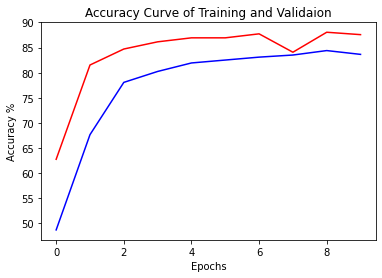

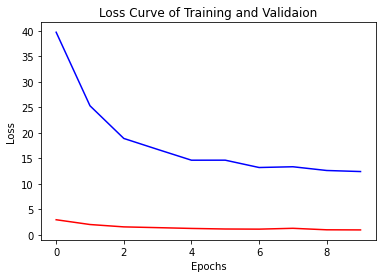

(3, 3)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


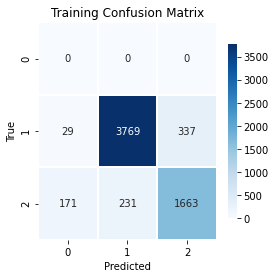

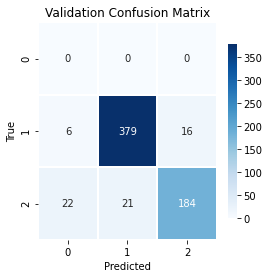

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  resnet18.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # 
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    label=labels
    labels= torch.nn.functional.one_hot(labels, len(class_names))
    for i in range(labels[:,0].shape[0]):
      if(labels[:,0][i]==1):
        labels[:,2][i]=1

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = resnet18(inputs)               #----> forward pass
    # _, predict = torch.max(outputs.data, 1)
  
    loss = criterion(outputs, labels.float())   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    
    limit = Variable(torch.Tensor([0.50])).to(device)
    # # print("Before",outputs)
    # # outputs=torch.Sigmoid(outputs)
    # o=outputs.cpu()
    # o=o.detach().numpy()
    # outputs = 1/(1 + np.exp(-o))
    # # print("Afterr",outputs)
    
    predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    # print("labeleddd", labels)
    # print("outputedd",outputs)
    # print("predicted", predicted)
    
    # total_correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    total_correct += get_num_correct(predicted, labels)
    
    predicted= predicted.cpu().numpy()
    outputs= outputs.cpu().detach().numpy()
    # print("After",predicted)

    for i in range(outputs.shape[0]):
      
      
      
      if (predicted[i]==[1,0,1]).all():
        train_p.extend([0])
        counter+=1
      elif (predicted[i]==[0,1,0]).all():
        train_p.extend([1])
      elif (predicted[i]==[0,0,1]).all():
         train_p.extend([2])
      else:
          l=outputs[i].argmax(axis=0)
          # print("Predicted",predicted[i])
          # print("label:",l)
          train_p.extend([l])

        



    # train_p.extend(predicted)
    train_l.extend(label.cpu().numpy())

    # print("train predicted",train_p)
    
    # print("train label",train_l)

    pbar.set_description(
        
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss,"counter:",counter)
  torch.save(resnet18,"‘res18_focal_loss_exp5.pth")

  resnet18.eval()
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import multilabel_confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  counter=0
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          label=labels
          labels= torch.nn.functional.one_hot(labels, len(class_names))
          for i in range(labels[:,0].shape[0]):
            if(labels[:,0][i]==1):
              labels[:,2][i]=1


          outputs = resnet18(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)

          limit = Variable(torch.Tensor([0.50])).to(device)
          predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    

          loss = criterion(outputs, labels.float())

          correct += get_num_correct(predicted, labels)
          # print("Predicted",predicted)
          # print("Labels",labels)
          
          running_loss += loss.item()
          predicted= predicted.cpu().numpy()
          outputs=outputs.cpu().detach().numpy()

          for i in range(outputs.shape[0]):
            
            
            
            if (predicted[i]==[1,0,1]).all():
              valid_p.extend([0])
              counter+=1
            elif (predicted[i]==[0,1,0]).all():
              valid_p.extend([1])
            elif (predicted[i]==[0,0,1]).all():
              valid_p.extend([2])              # labels[:,2][i]=1
            else:
              l=outputs[i].argmax(axis=0)
              # print("Predicted",predicted[i])
              # print("label:",l)
              valid_p.extend([l])
              
              
            
          # valid_p.extend(predicted)
          valid_l.extend(label.cpu().numpy())
          # print(".",correct)
  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss,"counter:",counter)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)
print(train_input.shape)
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Validation Confusion Matrix")
plt.show()

# from sklearn.metrics import f1_score
# print("Training   F1 Score :",f1_score(train_l, train_p)) # p are predicted labels and l are true labels
# print("Validation F1 Score :",f1_score(valid_l, valid_p)) # p are predicted labels and l are true labels


# **Training Loop (Alpha=1.5, Gamma=0.25, LR=0.001)**

In [0]:
def get_num_correct(preds, labs):
    # return preds.argmax(dim=1).eq(labels).sum().item()
    return torch.sum(torch.all(torch.eq(preds, labs),dim=1)).item()


Epochs = 10
criterion = FocalLoss(alpha=1.5,gamma=0.25)
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)


Train Epoch: 0 [3080/6200 (57%)]	Loss: 0.427914: : 97it [02:12,  1.37s/it]


Train: epoch:  0 total_correct:  2903.0 total_loss:  51.53259080648422 counter: 0
Valid: epoch:  0 total_correct:  367 total_loss:  4.13365051150322 counter: 0
 


Train Epoch: 1 [3080/6200 (57%)]	Loss: 0.345280: : 97it [02:12,  1.37s/it]


Train: epoch:  1 total_correct:  4318.0 total_loss:  33.347783759236336 counter: 0
Valid: epoch:  1 total_correct:  500 total_loss:  2.752171754837036 counter: 0
 


Train Epoch: 2 [3080/6200 (57%)]	Loss: 0.133737: : 97it [02:12,  1.36s/it]


Train: epoch:  2 total_correct:  4887.0 total_loss:  26.01247550547123 counter: 0
Valid: epoch:  2 total_correct:  522 total_loss:  2.250540927052498 counter: 0
 


Train Epoch: 3 [3080/6200 (57%)]	Loss: 0.209978: : 97it [02:12,  1.37s/it]


Train: epoch:  3 total_correct:  5045.0 total_loss:  23.290937528014183 counter: 0
Valid: epoch:  3 total_correct:  540 total_loss:  2.15971577167511 counter: 0
 


Train Epoch: 4 [3080/6200 (57%)]	Loss: 0.168684: : 97it [02:10,  1.35s/it]


Train: epoch:  4 total_correct:  5119.0 total_loss:  21.090508736670017 counter: 0
Valid: epoch:  4 total_correct:  539 total_loss:  1.9730881303548813 counter: 0
 


Train Epoch: 5 [3080/6200 (57%)]	Loss: 0.188638: : 97it [02:09,  1.34s/it]


Train: epoch:  5 total_correct:  5165.0 total_loss:  20.737565591931343 counter: 0
Valid: epoch:  5 total_correct:  521 total_loss:  1.9532565772533417 counter: 0
 


Train Epoch: 6 [3080/6200 (57%)]	Loss: 0.152027: : 97it [02:09,  1.34s/it]


Train: epoch:  6 total_correct:  5216.0 total_loss:  19.55548395961523 counter: 0
Valid: epoch:  6 total_correct:  523 total_loss:  2.106294870376587 counter: 0
 


Train Epoch: 7 [3080/6200 (57%)]	Loss: 0.125860: : 97it [02:14,  1.39s/it]


Train: epoch:  7 total_correct:  5235.0 total_loss:  18.454882122576237 counter: 0
Valid: epoch:  7 total_correct:  545 total_loss:  1.6726676002144814 counter: 0
 


Train Epoch: 8 [3080/6200 (57%)]	Loss: 0.266909: : 97it [02:12,  1.37s/it]


Train: epoch:  8 total_correct:  5249.0 total_loss:  18.368625290691853 counter: 0
Valid: epoch:  8 total_correct:  527 total_loss:  1.929795354604721 counter: 0
 


Train Epoch: 9 [3080/6200 (57%)]	Loss: 0.185147: : 97it [02:13,  1.38s/it]


Train: epoch:  9 total_correct:  5284.0 total_loss:  18.13425286114216 counter: 0
Valid: epoch:  9 total_correct:  532 total_loss:  1.8211662620306015 counter: 0
 
Training Accuracy 85.2258064516129 %
Validation Accuracy 84.71337579617834 %
Finished Training


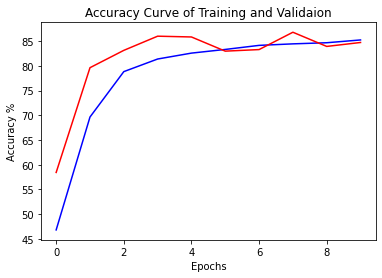

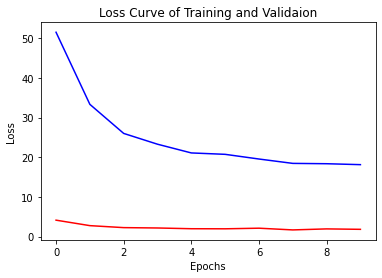

(3, 3)


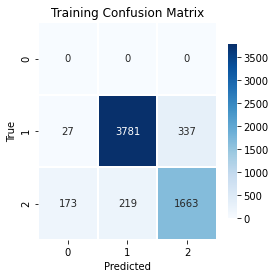

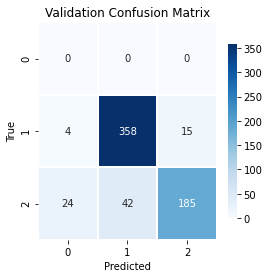

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  resnet18.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # 
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    label=labels
    labels= torch.nn.functional.one_hot(labels, len(class_names))
    for i in range(labels[:,0].shape[0]):
      if(labels[:,0][i]==1):
        labels[:,2][i]=1

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = resnet18(inputs)               #----> forward pass
    # _, predict = torch.max(outputs.data, 1)
  
    loss = criterion(outputs, labels.float())   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    
    limit = Variable(torch.Tensor([0.50])).to(device)
    # # print("Before",outputs)
    # # outputs=torch.Sigmoid(outputs)
    # o=outputs.cpu()
    # o=o.detach().numpy()
    # outputs = 1/(1 + np.exp(-o))
    # # print("Afterr",outputs)
    
    predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    # print("labeleddd", labels)
    # print("outputedd",outputs)
    # print("predicted", predicted)
    
    # total_correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    total_correct += get_num_correct(predicted, labels)
    
    predicted= predicted.cpu().numpy()
    outputs= outputs.cpu().detach().numpy()
    # print("After",predicted)

    for i in range(outputs.shape[0]):
      
      
      
      if (predicted[i]==[1,0,1]).all():
        train_p.extend([0])
        counter+=1
      elif (predicted[i]==[0,1,0]).all():
        train_p.extend([1])
      elif (predicted[i]==[0,0,1]).all():
         train_p.extend([2])
      else:
          l=outputs[i].argmax(axis=0)
          # print("Predicted",predicted[i])
          # print("label:",l)
          train_p.extend([l])

        



    # train_p.extend(predicted)
    train_l.extend(label.cpu().numpy())

    # print("train predicted",train_p)
    
    # print("train label",train_l)

    pbar.set_description(
        
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss,"counter:",counter)
  torch.save(resnet18,"‘res18_focal_loss_exp6.pth")

  resnet18.eval()
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import multilabel_confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  counter=0
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          label=labels
          labels= torch.nn.functional.one_hot(labels, len(class_names))
          for i in range(labels[:,0].shape[0]):
            if(labels[:,0][i]==1):
              labels[:,2][i]=1


          outputs = resnet18(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)

          limit = Variable(torch.Tensor([0.50])).to(device)
          predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    

          loss = criterion(outputs, labels.float())

          correct += get_num_correct(predicted, labels)
          # print("Predicted",predicted)
          # print("Labels",labels)
          
          running_loss += loss.item()
          predicted= predicted.cpu().numpy()
          outputs=outputs.cpu().detach().numpy()

          for i in range(outputs.shape[0]):
            
            
            
            if (predicted[i]==[1,0,1]).all():
              valid_p.extend([0])
              counter+=1
            elif (predicted[i]==[0,1,0]).all():
              valid_p.extend([1])
            elif (predicted[i]==[0,0,1]).all():
              valid_p.extend([2])              # labels[:,2][i]=1
            else:
              l=outputs[i].argmax(axis=0)
              # print("Predicted",predicted[i])
              # print("label:",l)
              valid_p.extend([l])
              
              
            
          # valid_p.extend(predicted)
          valid_l.extend(label.cpu().numpy())
          # print(".",correct)
  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss,"counter:",counter)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)
print(train_input.shape)
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Validation Confusion Matrix")
plt.show()

# from sklearn.metrics import f1_score
# print("Training   F1 Score :",f1_score(train_l, train_p)) # p are predicted labels and l are true labels
# print("Validation F1 Score :",f1_score(valid_l, valid_p)) # p are predicted labels and l are true labels


# **Training Loop (Alpha=0.5, Gamma=4, LR=0.001)**

In [0]:
def get_num_correct(preds, labs):
    # return preds.argmax(dim=1).eq(labels).sum().item()
    return torch.sum(torch.all(torch.eq(preds, labs),dim=1)).item()


Epochs = 10
criterion = FocalLoss(alpha=0.5,gamma=4)
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)


In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

train_acc=[]
valid_acc=[]

train_loss=[]
valid_loss=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

  resnet18.train()
  running_loss = 0.0
  total_correct=0.0
  counter=0
  # 
  train_p=[]
  train_l=[]
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:

    
    # get the inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    label=labels
    labels= torch.nn.functional.one_hot(labels, len(class_names))
    for i in range(labels[:,0].shape[0]):
      if(labels[:,0][i]==1):
        labels[:,2][i]=1

    # zero the parameter gradients
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    # This is convenient while training RNNs. 
    # So, the default action is to accumulate the gradients on every loss.backward() call

    # forward + backward + optimize
    outputs = resnet18(inputs)               #----> forward pass
    # _, predict = torch.max(outputs.data, 1)
  
    loss = criterion(outputs, labels.float())   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update

    # print statistics
    running_loss += loss.item()
    
    limit = Variable(torch.Tensor([0.50])).to(device)
    # # print("Before",outputs)
    # # outputs=torch.Sigmoid(outputs)
    # o=outputs.cpu()
    # o=o.detach().numpy()
    # outputs = 1/(1 + np.exp(-o))
    # # print("Afterr",outputs)
    
    predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    # print("labeleddd", labels)
    # print("outputedd",outputs)
    # print("predicted", predicted)
    
    # total_correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    total_correct += get_num_correct(predicted, labels)
    
    predicted= predicted.cpu().numpy()
    outputs= outputs.cpu().detach().numpy()
    # print("After",predicted)

    for i in range(outputs.shape[0]):
      
      
      
      if (predicted[i]==[1,0,1]).all():
        train_p.extend([0])
        counter+=1
      elif (predicted[i]==[0,1,0]).all():
        train_p.extend([1])
      elif (predicted[i]==[0,0,1]).all():
         train_p.extend([2])
      else:
          l=outputs[i].argmax(axis=0)
          # print("Predicted",predicted[i])
          # print("label:",l)
          train_p.extend([l])

        



    # train_p.extend(predicted)
    train_l.extend(label.cpu().numpy())

    # print("train predicted",train_p)
    
    # print("train label",train_l)

    pbar.set_description(
        
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
  

  a=(total_correct*100)/len(train_data)  
  train_acc.append(a)
  train_loss.append(running_loss)
  print("Train:","epoch: ", epoch, "total_correct: ", total_correct, "total_loss: ", running_loss,"counter:",counter)
  torch.save(resnet18,"‘res18_focal_loss_exp.pth")

  resnet18.eval()
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import multilabel_confusion_matrix
  correct = 0
  total = 0

  running_loss=0.0

  valid_p=[]
  valid_l=[]
  counter=0
  with torch.no_grad():
      for data in validloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          label=labels
          labels= torch.nn.functional.one_hot(labels, len(class_names))
          for i in range(labels[:,0].shape[0]):
            if(labels[:,0][i]==1):
              labels[:,2][i]=1


          outputs = resnet18(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)

          limit = Variable(torch.Tensor([0.50])).to(device)
          predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
    

          loss = criterion(outputs, labels.float())

          correct += get_num_correct(predicted, labels)
          # print("Predicted",predicted)
          # print("Labels",labels)
          
          running_loss += loss.item()
          predicted= predicted.cpu().numpy()
          outputs=outputs.cpu().detach().numpy()

          for i in range(outputs.shape[0]):
            
            
            
            if (predicted[i]==[1,0,1]).all():
              valid_p.extend([0])
              counter+=1
            elif (predicted[i]==[0,1,0]).all():
              valid_p.extend([1])
            elif (predicted[i]==[0,0,1]).all():
              valid_p.extend([2])              # labels[:,2][i]=1
            else:
              l=outputs[i].argmax(axis=0)
              # print("Predicted",predicted[i])
              # print("label:",l)
              valid_p.extend([l])
              
              
            
          # valid_p.extend(predicted)
          valid_l.extend(label.cpu().numpy())
          # print(".",correct)
  valid_acc.append((100 * correct) / total)
  valid_loss.append(running_loss)
  print("Valid:","epoch: ", epoch, "total_correct: ", correct, "total_loss: ", running_loss,"counter:",counter)
  print(" ")

print("Training Accuracy",a,"%")

print("Validation Accuracy",((100 * correct) / total),"%")

print('Finished Training')



plt.plot(train_acc, color="b")
plt.plot(valid_acc, color="r")
plt.title("Accuracy Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

plt.plot(train_loss, color="b")
plt.plot(valid_loss, color="r")
plt.title("Loss Curve of Training and Validaion")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.show()

train_input=confusion_matrix(train_p,train_l)
valid_input=confusion_matrix(valid_p,valid_l)
print(train_input.shape)
import seaborn as sns
plt.subplots(figsize=(4,4))
ax = sns.heatmap(train_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Training Confusion Matrix")
plt.show()

plt.subplots(figsize=(4,4))
ax = sns.heatmap(valid_input,cmap="Blues", annot=True, fmt="d",linewidths=1.0,cbar_kws={"shrink": .80})
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
plt.title("Validation Confusion Matrix")
plt.show()

# from sklearn.metrics import f1_score
# print("Training   F1 Score :",f1_score(train_l, train_p)) # p are predicted labels and l are true labels
# print("Validation F1 Score :",f1_score(valid_l, valid_p)) # p are predicted labels and l are true labels


# ***Load Testing Data and Test***

In [0]:
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):    
    def __getitem__(self, index):
        img_lab = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        img_lab_path = (img_lab + (path,))
        return img_lab_path

test_data = ImageFolderWithPaths(root='Test', transform=test_transforms)
testloader = torch.utils.data.DataLoader(dataset=test_data,batch_size=64,shuffle=True,num_workers=4)
print("Total Test Images:",len(test_data))
len(testloader)

Total Test Images: 629


10

# **Testing Resnet-18 Focal Loss**

In [0]:
import csv
import pandas as pd

def append_list_as_row(file_name, list_of_elem):
    with open(file_name, 'a+', newline='') as write_obj:
        csv_writer = csv.writer(write_obj)
        csv_writer.writerow(list_of_elem)


resnet18=torch.load("res18_focal_loss_exp3.pth")
resnet18.eval()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
correct = 0
total = 0
running_loss=0.0
test_p=[]
test_l=[]
predicted_csv=[]
labels_csv=[]
counter=0
with torch.no_grad():
    for data in testloader:
        images, labels, paths = data
        images, labels = images.to(device), labels.to(device)
        
        label=labels
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        for i in range(labels[:,0].shape[0]):
          if(labels[:,0][i]==1):
            labels[:,2][i]=1

        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        limit = Variable(torch.Tensor([0.50])).to(device)
        predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
  
        loss = criterion(outputs, labels.float())

        correct += get_num_correct(predicted, labels)
        # print("Predicted",predicted)
        # print("Labels",labels)
        
        running_loss += loss.item()
        predicted= predicted.cpu().numpy()
        
        predicted_csv.extend(predicted)
        labels_csv.extend(label)

        outputs=outputs.cpu().detach().numpy()

        for i in range(outputs.shape[0]):         
          if (predicted[i]==[1,0,1]).all():
            test_p.extend([0])
            counter+=1
          elif (predicted[i]==[0,1,0]).all():
            test_p.extend([1])
          elif (predicted[i]==[0,0,1]).all():
            test_p.extend([2])              # labels[:,2][i]=1
          else:
            l=outputs[i].argmax(axis=0)
            test_p.extend([l])

          if(predicted[i]==[0,0,0]).all():
            ll=outputs[i].argmax(axis=0)
            # print("Phly",predicted[i])
            predicted[i][ll]=1
            # print("Baad",predicted[i])
            

          # paths working here................
          name=(paths[i].rsplit('/',1)[1])
          rows=[name,predicted[i][0],predicted[i][2],predicted[i][1]]
          append_list_as_row('resnet18_focal_loss.csv', rows)
           
        test_l.extend(label.cpu().numpy())
        

# **Testing VGG16 Focal Loss**

In [0]:
import csv
import pandas as pd

def append_list_as_row(file_name, list_of_elem):
    with open(file_name, 'a+', newline='') as write_obj:
        csv_writer = csv.writer(write_obj)
        csv_writer.writerow(list_of_elem)


vgg16=torch.load("vgg16_focal_loss_exp5.pth")
vgg16.eval()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
correct = 0
total = 0
running_loss=0.0
test_p=[]
test_l=[]
predicted_csv=[]
labels_csv=[]
counter=0
with torch.no_grad():
    for data in testloader:
        images, labels, paths = data
        images, labels = images.to(device), labels.to(device)
        
        label=labels
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        for i in range(labels[:,0].shape[0]):
          if(labels[:,0][i]==1):
            labels[:,2][i]=1

        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        limit = Variable(torch.Tensor([0.50])).to(device)
        predicted = torch.where(outputs < limit, Variable(torch.Tensor([0])).to(device), Variable(torch.Tensor([1])).to(device)) # produce labels 0 and 1
  
        loss = criterion(outputs, labels.float())

        correct += get_num_correct(predicted, labels)
        # print("Predicted",predicted)
        # print("Labels",labels)
        
        running_loss += loss.item()
        predicted= predicted.cpu().numpy()
        
        predicted_csv.extend(predicted)
        labels_csv.extend(label)

        outputs=outputs.cpu().detach().numpy()

        for i in range(outputs.shape[0]):         
          if (predicted[i]==[1,0,1]).all():
            test_p.extend([0])
            counter+=1
          elif (predicted[i]==[0,1,0]).all():
            test_p.extend([1])
          elif (predicted[i]==[0,0,1]).all():
            test_p.extend([2])              # labels[:,2][i]=1
          else:
            l=outputs[i].argmax(axis=0)
            test_p.extend([l])

          if(predicted[i]==[0,0,0]).all():
            ll=outputs[i].argmax(axis=0)
            # print("Phly",predicted[i])
            predicted[i][ll]=1
            # print("Baad",predicted[i])
            

          # paths working here................
          name=(paths[i].rsplit('/',1)[1])
          rows=[name,predicted[i][0],predicted[i][2],predicted[i][1]]
          append_list_as_row('vgg16_focal_loss.csv', rows)
           
        test_l.extend(label.cpu().numpy())
        